In [2]:
import os, pickle, cloudpickle
import pandas as pd
import numpy as np
import shapely, shapely.wkt
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import os.path as path
pd.set_option('display.max_rows', 10)
# sns.set()
# sns.color_palette("ch:s=.25,rot=-.25")
# np.set_printoptions(suppress=True)


Bad key "text.kerning_factor" on line 4 in
/Users/yhannnn/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
# specify number of stations want to increase
NUM_STATIONS_INC = 1

In [4]:
# specify dir
CITY = "C_"
save_dir = CITY + 'reg_res/'
save_dir_preprocess = os.path.join(save_dir, CITY + 'preprocess_fig/')
save_dir_models = os.path.join(save_dir, CITY + 'model_res/') 
save_dir_forecast = os.path.join(save_dir, CITY + 'forecast/')
save_dir_fairst = os.path.join(save_dir, CITY + 'fairst/')


In [5]:
# load unmitigated random forest
with open(os.path.join(save_dir_models, CITY + "random_forest.pkl"), 'rb') as file:  
    rf_best = pickle.load(file)

# load exponentiated gradient
with open(os.path.join(save_dir_models, CITY + "exp_grad.pkl"), 'rb') as file:  
    eg_best = cloudpickle.load(file)

# load grid search
with open(os.path.join(save_dir_models, CITY + "grid_search.pkl"), 'rb') as file:  
    gs_best = pickle.load(file)

In [6]:
# load necessary datasets
df_all = pd.read_csv(os.path.join(save_dir_forecast, CITY + "df_all.csv"), index_col = 0)
df_weather = pd.read_csv(os.path.join(save_dir_forecast, CITY + "df_weather.csv"), index_col = 0)
df_weather.year = df_weather.year.astype(int)
df_weather.month = df_weather.month.astype(int)
X_train = pd.read_csv(os.path.join(save_dir_forecast, CITY + "X_train.csv"), index_col = 0)
df_geo = pd.read_csv(os.path.join(save_dir_forecast, CITY + "df_geo.csv"), index_col = 0)
for row,col in df_geo.iterrows():
    df_geo.at[row, 'geometry'] = shapely.wkt.loads(df_geo.loc[row]['geometry'])
df_geo = df_geo[["cell_num", "geometry", "centroid"]]

In [7]:
df_geo

,cell_num,geometry,centroid
0,104,POLYGON ((-85.46347245413803 34.98311234314082...,POINT (-85.46117705986944 34.98540773740939)
1,105,POLYGON ((-85.46347245413803 34.98770313167797...,POINT (-85.46117705986944 34.98999852594654)
2,156,POLYGON ((-85.45888166560087 34.98311234314082...,POINT (-85.4565862713323 34.98540773740939)
3,157,POLYGON ((-85.45888166560087 34.98770313167797...,POINT (-85.4565862713323 34.98999852594654)
4,158,POLYGON ((-85.45888166560087 34.99229392021512...,POINT (-85.4565862713323 34.99458931448369)
...,...,...,...
1825,4651,POLYGON ((-85.06407385140531 35.08870047949528...,POINT (-85.06177845713674 35.09099587376386)
1826,4652,POLYGON ((-85.06407385140531 35.09329126803243...,POINT (-85.06177845713674 35.095586662301)
1827,4704,POLYGON ((-85.05948306286815 35.09329126803243...,POINT (-85.05718766859957 35.095586662301)
1828,4705,POLYGON ((-85.05948306286815 35.09788205656958...,POINT (-85.05718766859957 35.10017745083816)


In [8]:
# duplicate rows 
df_forc = pd.DataFrame(np.repeat(df_all.values, 12, axis=0))
df_forc.columns = df_all.columns
int_col = ["cell_num", "tract_id", "stations", "capacity", "total_population",
           "total_housing_units", "median_income", "walk_score", "bike_score", "transit_score",
           "population_over_16", "population_over_16_employed", "population_over_16_unemployed",
           "nearby_bus", "nearby_rail", "nearby_other", "nearby_routes"]
for col in int_col:
    df_forc[col] = df_forc[col].astype(int)
    
# load weather
df_weather_19 = df_weather[df_weather.year == 2019]

# attach weather & month
for index, col in df_forc.iterrows():
    curr_month = index%12 + 1
    
    df_forc.at[index, "month"] = curr_month
    df_forc.at[index, "weather"] = df_weather_19[df_weather_19.month == curr_month].weather.values[0]

df_forc.month = df_forc.month.astype(int)

# save cell_num
cell_num = df_forc["cell_num"]
df_forc.drop(columns = "cell_num", inplace = True)

df_forc.head()

,tract_id,stations,capacity,total_population,total_housing_units,median_income,white_pct,black_pct,hispanic_pct,mean_travel_time_to_work,...,population_over_16_unemployed,walk_score,bike_score,transit_score,nearby_bus,nearby_rail,nearby_other,nearby_routes,month,weather
0,47065012100,0,0,6556,2922,59507,86.790726,8.221477,1.082977,19.581443,...,71,0,0,0,0,0,0,0,1,43.1
1,47065012100,0,0,6556,2922,59507,86.790726,8.221477,1.082977,19.581443,...,71,0,0,0,0,0,0,0,2,51.1
2,47065012100,0,0,6556,2922,59507,86.790726,8.221477,1.082977,19.581443,...,71,0,0,0,0,0,0,0,3,51.6
3,47065012100,0,0,6556,2922,59507,86.790726,8.221477,1.082977,19.581443,...,71,0,0,0,0,0,0,0,4,64.1
4,47065012100,0,0,6556,2922,59507,86.790726,8.221477,1.082977,19.581443,...,71,0,0,0,0,0,0,0,5,74.2


In [9]:
# select feature
df_forc.drop(columns = ['white_pct', 'black_pct', 'hispanic_pct', 'population_over_16', 
                   'pct_total_car_truck_van', "pct_bicycle", "tract_id"], inplace = True)

In [10]:
# training set
df_forc["income_group"] = 0

for row, col in df_forc.iterrows():
    
    if df_forc.loc[row]["median_income"] > 50000:
        df_forc.at[row, "income_group"] = 1
        
df_forc.drop(columns = ["median_income"], inplace = True)

# sns.countplot("income_group", data = df_forc)
# plt.title("Distribution of income")

In [11]:
# match order
df_forc = df_forc[X_train.columns]

In [12]:
# # scale
# columns_new = list(df_forc.columns)
# columns_new.remove('income_group')

# min_max_scaler = preprocessing.MinMaxScaler()
# df_scaled = min_max_scaler.fit_transform(df_forc.drop(columns = ['income_group']))
# df_scaled = pd.DataFrame(df_scaled, columns = columns_new)

# df_scaled["income_group"] = df_forc["income_group"]
# # df_scaled["stations"] = df["stations"]
# # df_scaled.outflow = min_max_scaler.fit_transform(df_scaled.outflow.values.reshape(-1, 1))
# df_forc = df_scaled

### prediction

In [13]:
# ## old prediction
# old_pred_random_forest = rf_best.predict(df_forc)
# old_pred_exp_grad = eg_best.predict(df_forc, random_state = 42)
# old_pred_grid_search = gs_best.predict(df_forc)

In [14]:
# increase stations by NUM_STATIONS_INC, then scale
df_forc_new = df_forc.copy()
df_forc_new["stations"] += NUM_STATIONS_INC

In [15]:
## new prediction
new_pred_random_forest = rf_best.predict(df_forc_new)
new_pred_exp_grad = eg_best.predict(df_forc_new, random_state = 42)
new_pred_grid_search = gs_best.predict(df_forc_new)

In [16]:
pred_df = cell_num.to_frame()
pred_df["month"] = df_forc_new["month"]
pred_df["income_group"] = df_forc_new["income_group"]
# pred_df["stations_added"] = df_forc_new["stations"]

In [17]:
pred_df["stations_added"] = df_forc_new["stations"]

In [18]:
cell_num2stations_df = pred_df.groupby("cell_num").mean().reset_index()[["cell_num", "stations_added"]]
# cell_num2stations_df.stations_added = cell_num2stations_df.stations_added.astype(int)
cell_num2stations_df

,cell_num,stations_added
0,104,1.0
1,105,1.0
2,156,1.0
3,157,1.0
4,158,1.0
...,...,...
1825,4651,1.0
1826,4652,1.0
1827,4704,1.0
1828,4705,1.0


In [19]:
pred_df["new_pred_random_forest"] = new_pred_random_forest
pred_df["new_pred_exp_grad"] = new_pred_exp_grad
pred_df["new_pred_grid_search"] = new_pred_grid_search

In [20]:
# pred_random_forest = pred_df[pred_df.random_forest_pred_diff > 0]
# pred_random_forest = pred_random_forest[["cell_num", "month", "income_group", "old_pred_random_forest", "new_pred_random_forest", "random_forest_pred_diff"]]

# pred_exp_grad = pred_df[pred_df.exp_grad_pred_diff > 0]
# pred_exp_grad = pred_exp_grad[["cell_num", "month", "income_group", "old_pred_exp_grad", "new_pred_exp_grad", "exp_grad_pred_diff"]]

# pred_grid_search = pred_df[pred_df.grid_search_pred_diff > 0]
# pred_grid_search = pred_grid_search[["cell_num", "month", "income_group", "old_pred_grid_search", "new_pred_grid_search", "grid_search_pred_diff"]]


In [21]:
# sum over months
# pred_random_forest_yearly = pred_random_forest.groupby("cell_num").sum().reset_index().drop(columns = ["month"])
# pred_random_forest_yearly["bi_income"] = pred_random_forest_yearly["income_group"].apply(lambda x: "high_income" if x > 0 else "low_income")
# pred_random_forest_yearly.drop(columns = ["income_group"], inplace = True)

# pred_exp_grad_yearly = pred_exp_grad.groupby("cell_num").sum().reset_index().drop(columns = ["month"])
# pred_exp_grad_yearly["bi_income"] = pred_exp_grad_yearly["income_group"].apply(lambda x: "high_income" if x > 0 else "low_income")
# pred_exp_grad_yearly.drop(columns = ["income_group"], inplace = True)

# pred_grid_search_yearly = pred_grid_search.groupby("cell_num").sum().reset_index().drop(columns = ["month"])
# pred_grid_search_yearly["bi_income"] = pred_grid_search_yearly["income_group"].apply(lambda x: "high_income" if x > 0 else "low_income")
# pred_grid_search_yearly.drop(columns = ["income_group"], inplace = True)

In [22]:
pred_df

,cell_num,month,income_group,stations_added,new_pred_random_forest,new_pred_exp_grad,new_pred_grid_search
0,104,1,1,1,87.229275,82.463078,110.520218
1,104,2,1,1,102.405228,90.159977,111.356884
2,104,3,1,1,155.007609,115.008078,119.456884
3,104,4,1,1,233.162381,258.352381,269.847857
4,104,5,1,1,286.010000,321.753492,275.625000
...,...,...,...,...,...,...,...
21955,4758,8,1,1,316.195476,338.201667,339.720000
21956,4758,9,1,1,315.345476,343.785000,364.466667
21957,4758,10,1,1,315.213810,326.177619,360.234524
21958,4758,11,1,1,141.166894,109.319982,115.474384


In [23]:
pred_df_yearly = pred_df.groupby("cell_num").sum().reset_index().drop(columns = ["month"])
pred_df_yearly

,cell_num,income_group,stations_added,new_pred_random_forest,new_pred_exp_grad,new_pred_grid_search
0,104,12,12,2346.644829,2458.137129,2281.560969
1,105,12,12,2346.644829,2458.137129,2281.560969
2,156,12,12,2346.644829,2458.137129,2281.560969
3,157,12,12,2346.644829,2458.137129,2281.560969
4,158,12,12,2346.644829,2458.137129,2281.560969
...,...,...,...,...,...,...
1825,4651,12,12,3076.909710,2904.428960,3291.110969
1826,4652,12,12,3076.909710,2904.428960,3291.110969
1827,4704,12,12,3076.909710,3079.545626,3310.050969
1828,4705,12,12,3076.909710,3079.545626,3310.050969


In [24]:
# attach # of stations info

pred_df_yearly = pred_df_yearly.merge(cell_num2stations_df, on = "cell_num", how = 'left')
# pred_random_forest_yearly = pred_random_forest_yearly.merge(cell_num2stations_df, on = "cell_num", how = 'left')
# pred_exp_grad_yearly = pred_exp_grad_yearly.merge(cell_num2stations_df, on = "cell_num", how = 'left')
# pred_grid_search_yearly = pred_grid_search_yearly.merge(cell_num2stations_df, on = "cell_num", how = 'left')

### analysis 1: visualize

In [25]:
# pred_random_forest_geo = pred_random_forest_yearly.merge(df_geo, on = "cell_num", how = "left")
# pred_exp_grad_geo = pred_exp_grad_yearly.merge(df_geo, on = "cell_num", how = "left")
# pred_grid_search_geo = pred_grid_search_yearly.merge(df_geo, on = "cell_num", how = "left")

# pred_random_forest_geo = gpd.GeoDataFrame(pred_random_forest_geo, crs='EPSG:2956', geometry='geometry')
# pred_exp_grad_geo = gpd.GeoDataFrame(pred_exp_grad_geo, crs='EPSG:2956', geometry='geometry')
# pred_grid_search_geo = gpd.GeoDataFrame(pred_grid_search_geo, crs='EPSG:2956', geometry='geometry')

In [26]:
pred_df_yearly_geo = pred_df_yearly.merge(df_geo, on = "cell_num", how = "left")
pred_df_yearly_geo = gpd.GeoDataFrame(pred_df_yearly_geo, crs='EPSG:2956', geometry='geometry')


In [27]:
# # plot one by one
# # type(pgh_grid_income.loc[0]['geometry'])
# # for row, col in pred_random_forest_geo.iterrows():
# #     pred_random_forest_geo.at[row, 'geometry'] = shapely.wkt.loads(pred_random_forest_geo.loc[row]['geometry'])

# pred_random_forest_geo.plot(column="old_pred_random_forest", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, vmax = 7500)
# plt.title("Unmitigated random forest forecast\n(before add 1 station)", fontsize=20)

# pred_random_forest_geo.plot(column="new_pred_random_forest", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, vmax = 7500)
# plt.title("Unmitigated random forest forecast\n(after add 1 station)", fontsize=20)

# pred_random_forest_geo.plot(column="random_forest_pred_diff", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, vmax = 400)
# plt.title("Unmitigated random forest forecast difference", fontsize=20)

# pred_random_forest_geo.plot(column="bi_income", cmap='hot', edgecolor = "grey", figsize=(7, 9),  
#                     legend = True, categorical = True)
# plt.title("Income groups distribution", fontsize=20)

In [28]:
# # unmitigated random forest
# fig, axes = plt.subplots(2,2, figsize = (12, 12))

# ax1=axes[0,0]
# ax2=axes[0,1]
# ax3=axes[1,0]
# ax4=axes[1,1]

# pred_random_forest_geo.plot(column="old_pred_random_forest", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, vmax = 7500, ax = ax1)
# ax1.set_title(("before increase {} station").format(NUM_STATIONS_INC), fontsize=15)

# pred_random_forest_geo.plot(column="new_pred_random_forest", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, vmax = 7500, ax = ax2)
# ax2.set_title(("after increase {} station").format(NUM_STATIONS_INC), fontsize=15)

# pred_random_forest_geo.plot(column="random_forest_pred_diff", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, vmax = 400, ax = ax3)
# ax3.set_title("difference", fontsize=15)

# pred_random_forest_geo.plot(column="bi_income", cmap='hot', edgecolor = "grey", figsize=(2, 2),  
#                     legend = True, categorical = True, ax = ax4)
# ax4.set_title("income groups distribution", fontsize=15)
# fig.suptitle('Visualisation of unmitigated random forest outflow forecast results\n(only display cells that has difference > 0)', fontsize=20)

# # plt.savefig("geographical_visualization.svg")

In [29]:
# # exponentiated gradient
# fig, axes = plt.subplots(2,2, figsize = (12, 12))

# ax1=axes[0,0]
# ax2=axes[0,1]
# ax3=axes[1,0]
# ax4=axes[1,1]

# pred_exp_grad_geo.plot(column="old_pred_exp_grad", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, vmax = 7500, ax = ax1)
# ax1.set_title(("before increase {} station").format(NUM_STATIONS_INC), fontsize=15)

# pred_exp_grad_geo.plot(column="new_pred_exp_grad", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, vmax = 7500, ax = ax2)
# ax2.set_title(("after increase {} station").format(NUM_STATIONS_INC), fontsize=15)

# pred_exp_grad_geo.plot(column="exp_grad_pred_diff", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, vmax = 400, ax = ax3)
# ax3.set_title("difference", fontsize=15)

# pred_exp_grad_geo.plot(column="bi_income", cmap='hot', edgecolor = "grey", figsize=(2, 2),  
#                     legend = True, categorical = True, ax = ax4)
# ax4.set_title("income groups distribution", fontsize=15)
# fig.suptitle('Visualisation of exponentiated gradient forecast results\n(only display cells that has difference > 0)', fontsize=20)

# # plt.savefig("geographical_visualization.svg")

In [30]:
# # grid search
# fig, axes = plt.subplots(2,2, figsize = (12, 12))

# ax1=axes[0,0]
# ax2=axes[0,1]
# ax3=axes[1,0]
# ax4=axes[1,1]

# pred_grid_search_geo.plot(column="old_pred_grid_search", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, vmax = 6000, ax = ax1)
# ax1.set_title(("before increase {} station").format(NUM_STATIONS_INC), fontsize=15)

# pred_grid_search_geo.plot(column="new_pred_grid_search", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, vmax = 6000, ax = ax2)
# ax2.set_title(("after increase {} station").format(NUM_STATIONS_INC), fontsize=15)

# pred_grid_search_geo.plot(column="grid_search_pred_diff", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, vmax = 400, ax = ax3)
# ax3.set_title("difference", fontsize=15)

# pred_grid_search_geo.plot(column="bi_income", cmap='hot', edgecolor = "grey", figsize=(2, 2),  
#                     legend = True, categorical = True, ax = ax4)
# ax4.set_title("income groups distribution", fontsize=15)
# fig.suptitle('Visualisation of grid search forecast results\n(only display cells that has difference > 0)', fontsize=20)

# # plt.savefig("geographical_visualization.svg")

### analysis 2: visualize 2

In [31]:
# # for income plt, plot all cells that have increase, regardless of models
# rf_inc_cell = pred_random_forest_geo[["cell_num", "bi_income", "geometry"]]
# eg_inc_cell = pred_exp_grad_geo[["cell_num", "bi_income", "geometry"]]
# gs_inc_cell = pred_grid_search_geo[["cell_num", "bi_income", "geometry"]]
# income_df = rf_inc_cell.merge(eg_inc_cell, how = 'outer').merge(gs_inc_cell, how = 'outer')

# pred_random_forest_geo_all = pred_random_forest_geo.copy()
# pred_exp_grad_geo_all = pred_exp_grad_geo.copy()
# pred_grid_search_geo_all = pred_grid_search_geo.copy()

In [32]:
# all_inc_cell = income_df.cell_num.unique()
# rf_inc_cell_left = list(set(all_inc_cell) - set(rf_inc_cell.cell_num))
# eg_inc_cell_left = list(set(all_inc_cell) - set(eg_inc_cell.cell_num))
# gs_inc_cell_left = list(set(all_inc_cell) - set(gs_inc_cell.cell_num))

# print(len(rf_inc_cell_left))
# print(len(eg_inc_cell_left))
# print(len(gs_inc_cell_left))

In [33]:
# for i in np.arange(len(rf_inc_cell_left)):
#     cell_left = rf_inc_cell_left[i]
#     df_idx = len(pred_random_forest_geo)
#     temp_income = income_df[income_df.cell_num == cell_left].bi_income.values[0]
#     temp_geometry = income_df[income_df.cell_num == cell_left].geometry.values[0]
#     pred_random_forest_geo_all.loc[df_idx + i] = [cell_left, 0, 0, 0, temp_income, 0, temp_geometry, 0]
    
# for i in np.arange(len(eg_inc_cell_left)):
#     cell_left = eg_inc_cell_left[i]
#     df_idx = len(pred_exp_grad_geo)
#     temp_income = income_df[income_df.cell_num == cell_left].bi_income.values[0]
#     temp_geometry = income_df[income_df.cell_num == cell_left].geometry.values[0]
#     pred_exp_grad_geo_all.loc[df_idx + i] = [cell_left, 0, 0, 0, temp_income, 0, temp_geometry, 0]
    
# for i in np.arange(len(gs_inc_cell_left)):
#     cell_left = gs_inc_cell_left[i]
#     df_idx = len(pred_grid_search_geo)
#     temp_income = income_df[income_df.cell_num == cell_left].bi_income.values[0]
#     temp_geometry = income_df[income_df.cell_num == cell_left].geometry.values[0]
#     pred_grid_search_geo_all.loc[df_idx + i] = [cell_left, 0, 0, 0, temp_income, 0, temp_geometry, 0]

# print(len(pred_random_forest_geo_all))
# print(len(pred_exp_grad_geo_all))    
# print(len(pred_grid_search_geo_all))

In [34]:
pred_df_yearly_geo["income_group"] = pred_df_yearly_geo["income_group"].apply(lambda x: "high_income" if x == 12 else "low_income")

In [35]:
pred_df_yearly_geo

,cell_num,income_group,stations_added_x,new_pred_random_forest,new_pred_exp_grad,new_pred_grid_search,stations_added_y,geometry,centroid
0,104,high_income,12,2346.644829,2458.137129,2281.560969,1.0,"POLYGON ((-85.46347 34.98311, -85.46347 34.987...",POINT (-85.46117705986944 34.98540773740939)
1,105,high_income,12,2346.644829,2458.137129,2281.560969,1.0,"POLYGON ((-85.46347 34.98770, -85.46347 34.992...",POINT (-85.46117705986944 34.98999852594654)
2,156,high_income,12,2346.644829,2458.137129,2281.560969,1.0,"POLYGON ((-85.45888 34.98311, -85.45888 34.987...",POINT (-85.4565862713323 34.98540773740939)
3,157,high_income,12,2346.644829,2458.137129,2281.560969,1.0,"POLYGON ((-85.45888 34.98770, -85.45888 34.992...",POINT (-85.4565862713323 34.98999852594654)
4,158,high_income,12,2346.644829,2458.137129,2281.560969,1.0,"POLYGON ((-85.45888 34.99229, -85.45888 34.996...",POINT (-85.4565862713323 34.99458931448369)
...,...,...,...,...,...,...,...,...,...
1825,4651,high_income,12,3076.909710,2904.428960,3291.110969,1.0,"POLYGON ((-85.06407 35.08870, -85.06407 35.093...",POINT (-85.06177845713674 35.09099587376386)
1826,4652,high_income,12,3076.909710,2904.428960,3291.110969,1.0,"POLYGON ((-85.06407 35.09329, -85.06407 35.097...",POINT (-85.06177845713674 35.095586662301)
1827,4704,high_income,12,3076.909710,3079.545626,3310.050969,1.0,"POLYGON ((-85.05948 35.09329, -85.05948 35.097...",POINT (-85.05718766859957 35.095586662301)
1828,4705,high_income,12,3076.909710,3079.545626,3310.050969,1.0,"POLYGON ((-85.05948 35.09788, -85.05948 35.102...",POINT (-85.05718766859957 35.10017745083816)


### fairST

In [36]:
fairst_forecast_inc1 = pd.read_csv(os.path.join(save_dir_fairst,  "fairst_forecast_inc_1.csv"), index_col = 0)
fairst_forecast_inc2 = pd.read_csv(os.path.join(save_dir_fairst,  "fairst_forecast_inc_2.csv"), index_col = 0)

In [37]:
for row, col in fairst_forecast_inc1.iterrows():
    fairst_forecast_inc1.at[row, 'geometry'] = shapely.wkt.loads(fairst_forecast_inc1.loc[row]['geometry'])

In [38]:
for row, col in fairst_forecast_inc2.iterrows():
    fairst_forecast_inc2.at[row, 'geometry'] = shapely.wkt.loads(fairst_forecast_inc2.loc[row]['geometry'])

In [39]:
fairst_forecast_inc1 = gpd.GeoDataFrame(fairst_forecast_inc1, crs='EPSG:2956', geometry='geometry')
fairst_forecast_inc2 = gpd.GeoDataFrame(fairst_forecast_inc2, crs='EPSG:2956', geometry='geometry')

In [40]:
fairst_forecast_inc1

,pos,outflow,cell_num,geometry,income_group
0,10_1,0.000000,521,"POLYGON ((-85.42675 34.98770, -85.42675 34.992...",1
1,10_2,0.000000,522,"POLYGON ((-85.42675 34.99229, -85.42675 34.996...",1
2,10_3,0.000000,523,"POLYGON ((-85.42675 34.99688, -85.42675 35.001...",1
3,10_4,0.000000,524,"POLYGON ((-85.42675 35.00148, -85.42675 35.006...",1
4,11_0,31.398713,572,"POLYGON ((-85.42216 34.98311, -85.42216 34.987...",1
...,...,...,...,...,...
1825,91_26,0.000000,4758,"POLYGON ((-85.05489 35.10247, -85.05489 35.107...",1
1826,9_0,31.398719,468,"POLYGON ((-85.43134 34.98311, -85.43134 34.987...",1
1827,9_1,0.000000,469,"POLYGON ((-85.43134 34.98770, -85.43134 34.992...",1
1828,9_2,0.000000,470,"POLYGON ((-85.43134 34.99229, -85.43134 34.996...",1


In [41]:
if NUM_STATIONS_INC == 1:
    fairst_forecast_inc = fairst_forecast_inc1
elif NUM_STATIONS_INC == 2: 
    fairst_forecast_inc = fairst_forecast_inc2

In [42]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [43]:
# grid search
fig, axes = plt.subplots(2, 2, figsize = (30, 30))# , figsize = (24, 6)

ax1=axes[0, 0]
ax2=axes[0, 1]
ax3=axes[1, 0]
ax4=axes[1, 1]

pred_df_yearly_geo.plot(column="new_pred_random_forest", cmap='Blues',edgecolor = "grey", figsize=(12, 10),  
                    legend = True, legend_kwds={'label': "outflow",'orientation': "vertical"}, ax = ax1)
ax1.set_title("Unmitigated Random Forest", fontsize=8)

pred_df_yearly_geo.plot(column="new_pred_exp_grad", cmap='Blues',edgecolor = "grey", figsize=(12, 10),  
                    legend = True, legend_kwds={'label': "outflow",'orientation': "vertical"}, ax = ax2)
ax2.set_title("Exponentiated Gradient", fontsize=8)

pred_df_yearly_geo.plot(column="new_pred_grid_search", cmap='Blues',edgecolor = "grey", figsize=(12, 10),  
                    legend = True, legend_kwds={'label': "outflow",'orientation': "vertical"}, ax = ax3)
ax3.set_title("Grid Search", fontsize=8)

fairst_forecast_inc.plot(column="outflow", cmap='Blues',edgecolor = "grey", figsize=(12, 10),  
                    legend = True, legend_kwds={'label': "outflow",'orientation': "vertical"}, ax = ax4)

ax4.set_title("FairST", fontsize=8)

fig.suptitle(('Chattanooga').format(NUM_STATIONS_INC), fontsize=10)

FIG_NAME = ("fig_after_inc_{}_station").format(NUM_STATIONS_INC)
plt.savefig(os.path.join(save_dir_forecast, CITY + FIG_NAME))

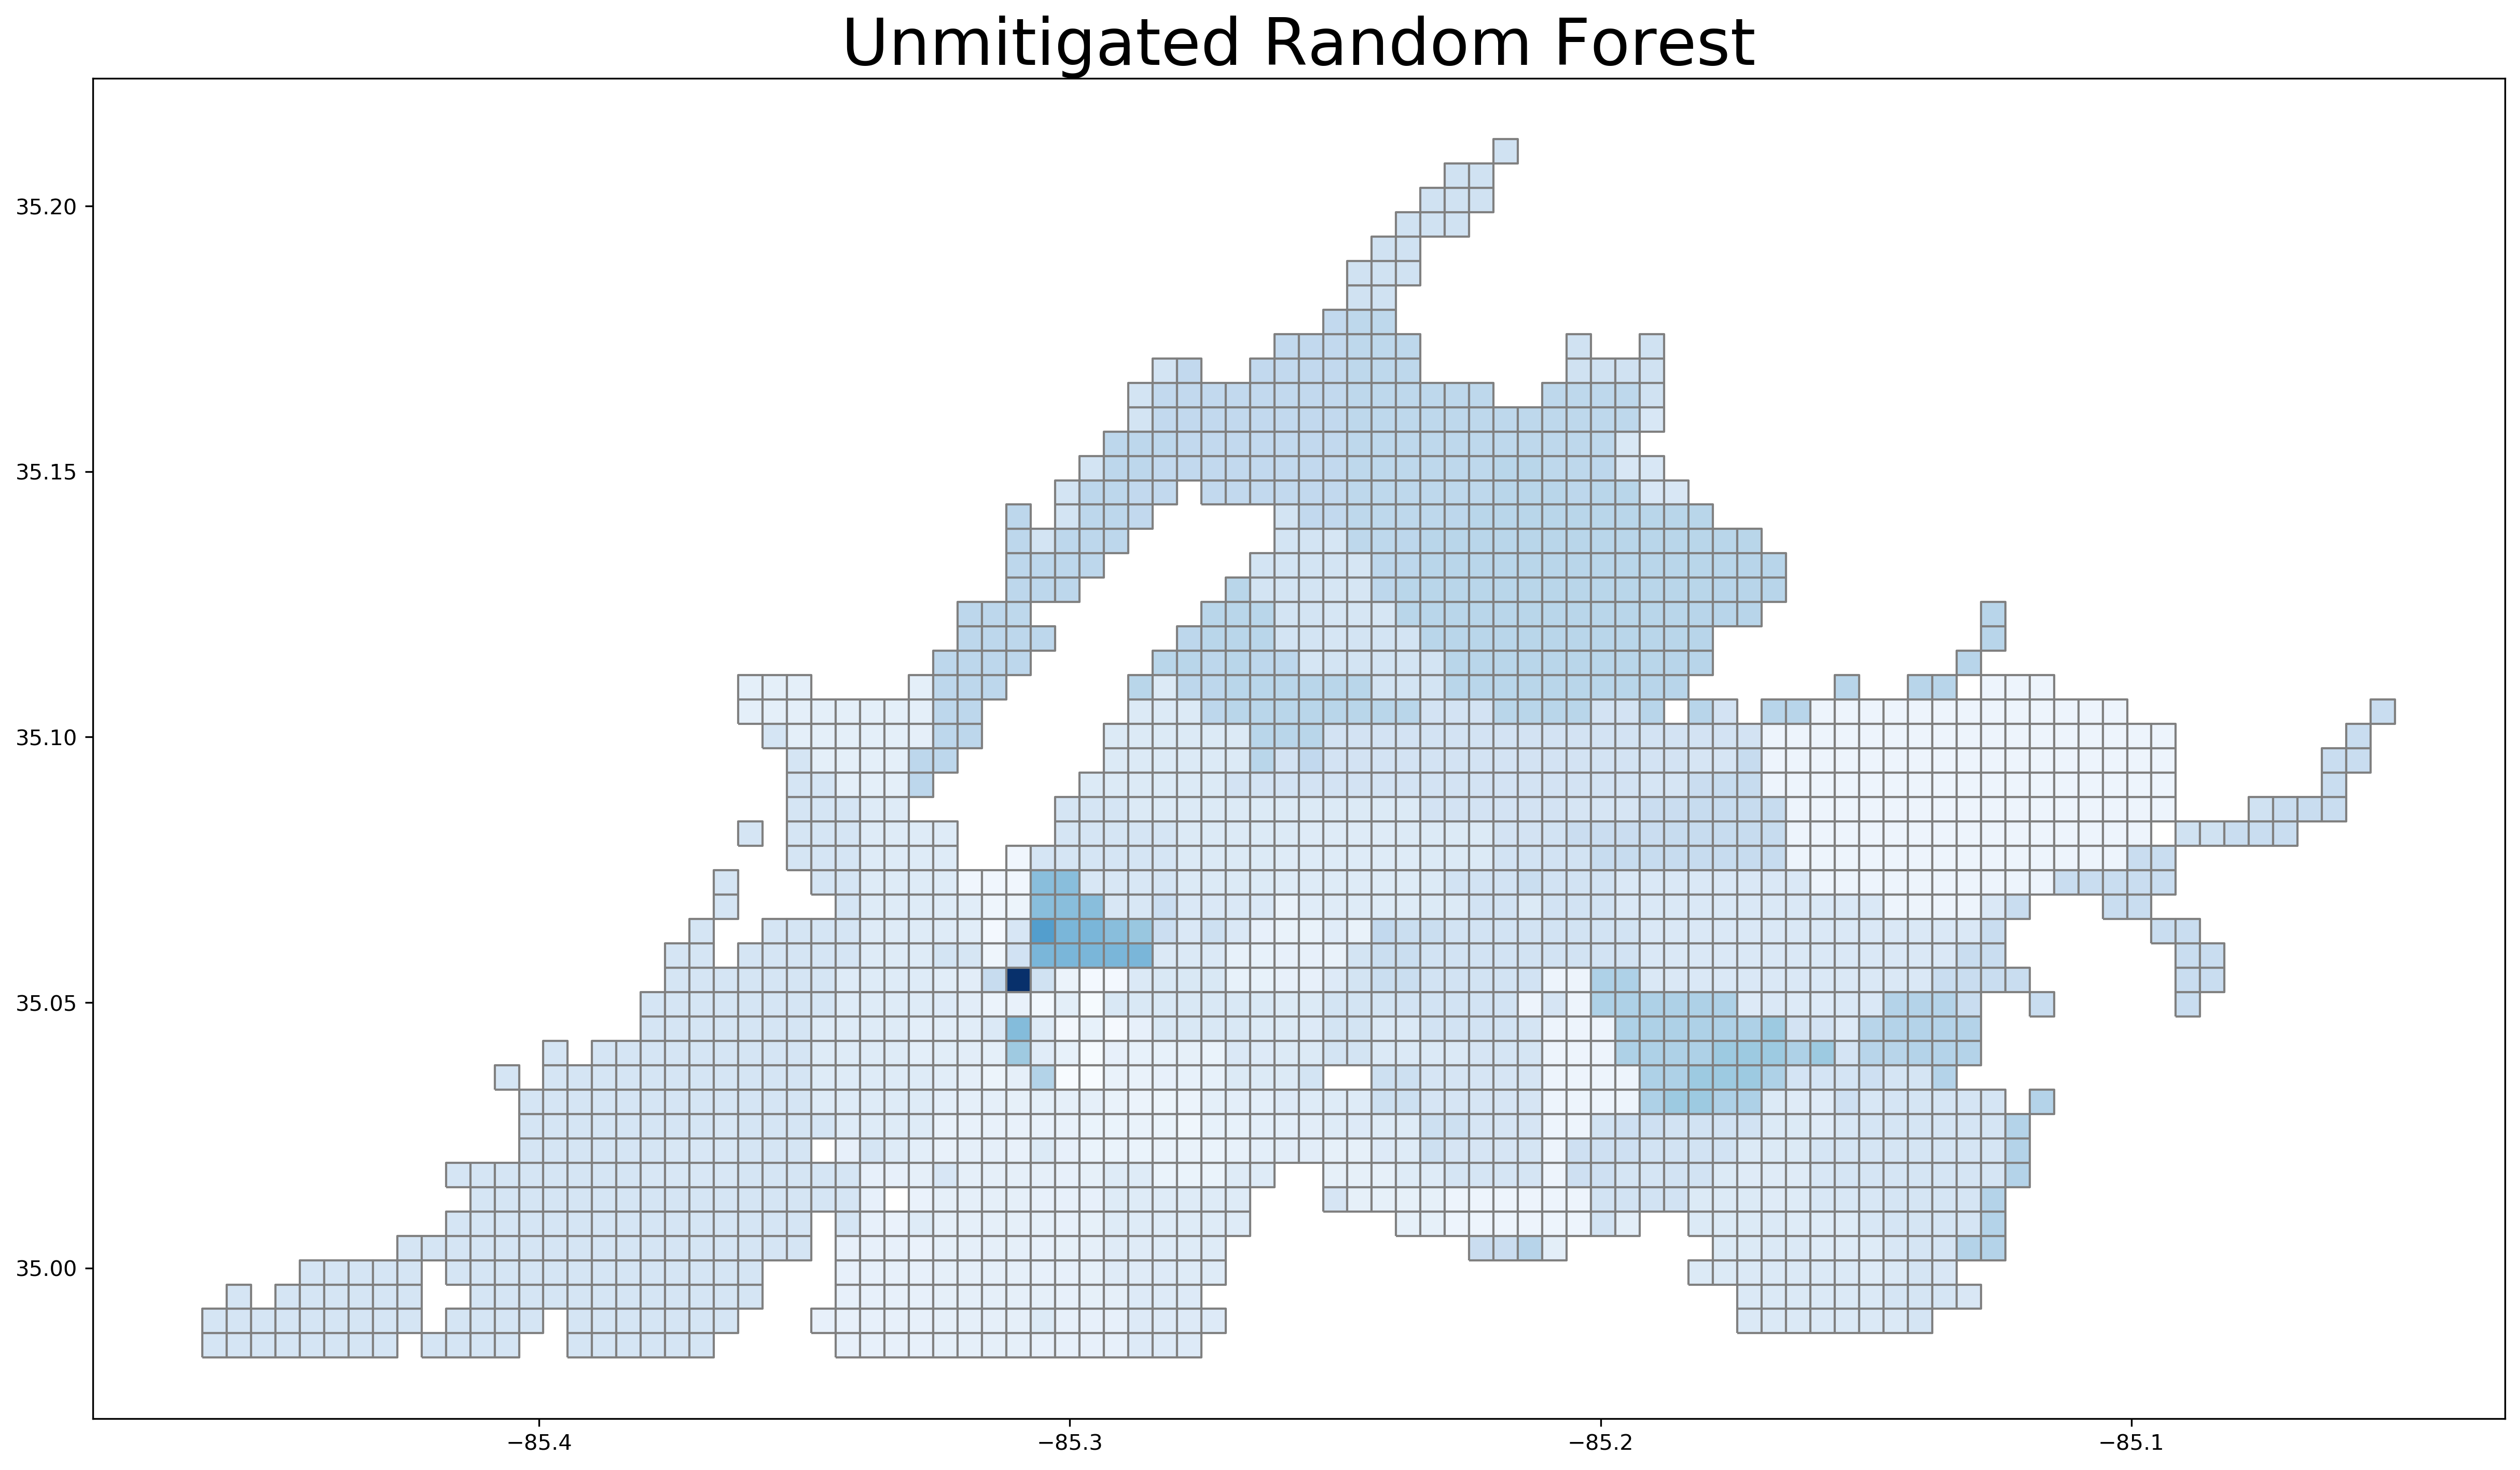

In [44]:
# plot 1
fig, axes = plt.subplots(figsize = (20, 16))
pred_df_yearly_geo.plot(column="new_pred_random_forest", cmap='Blues',edgecolor = "grey",
                    legend = False, legend_kwds={'label': "outflow",'orientation': "vertical"}, ax = axes, vmax = 12000)
axes.set_title("Unmitigated Random Forest", fontsize=30)
plt.savefig(os.path.join(save_dir_forecast, "FINAL_Unmitigated_" + CITY + FIG_NAME))

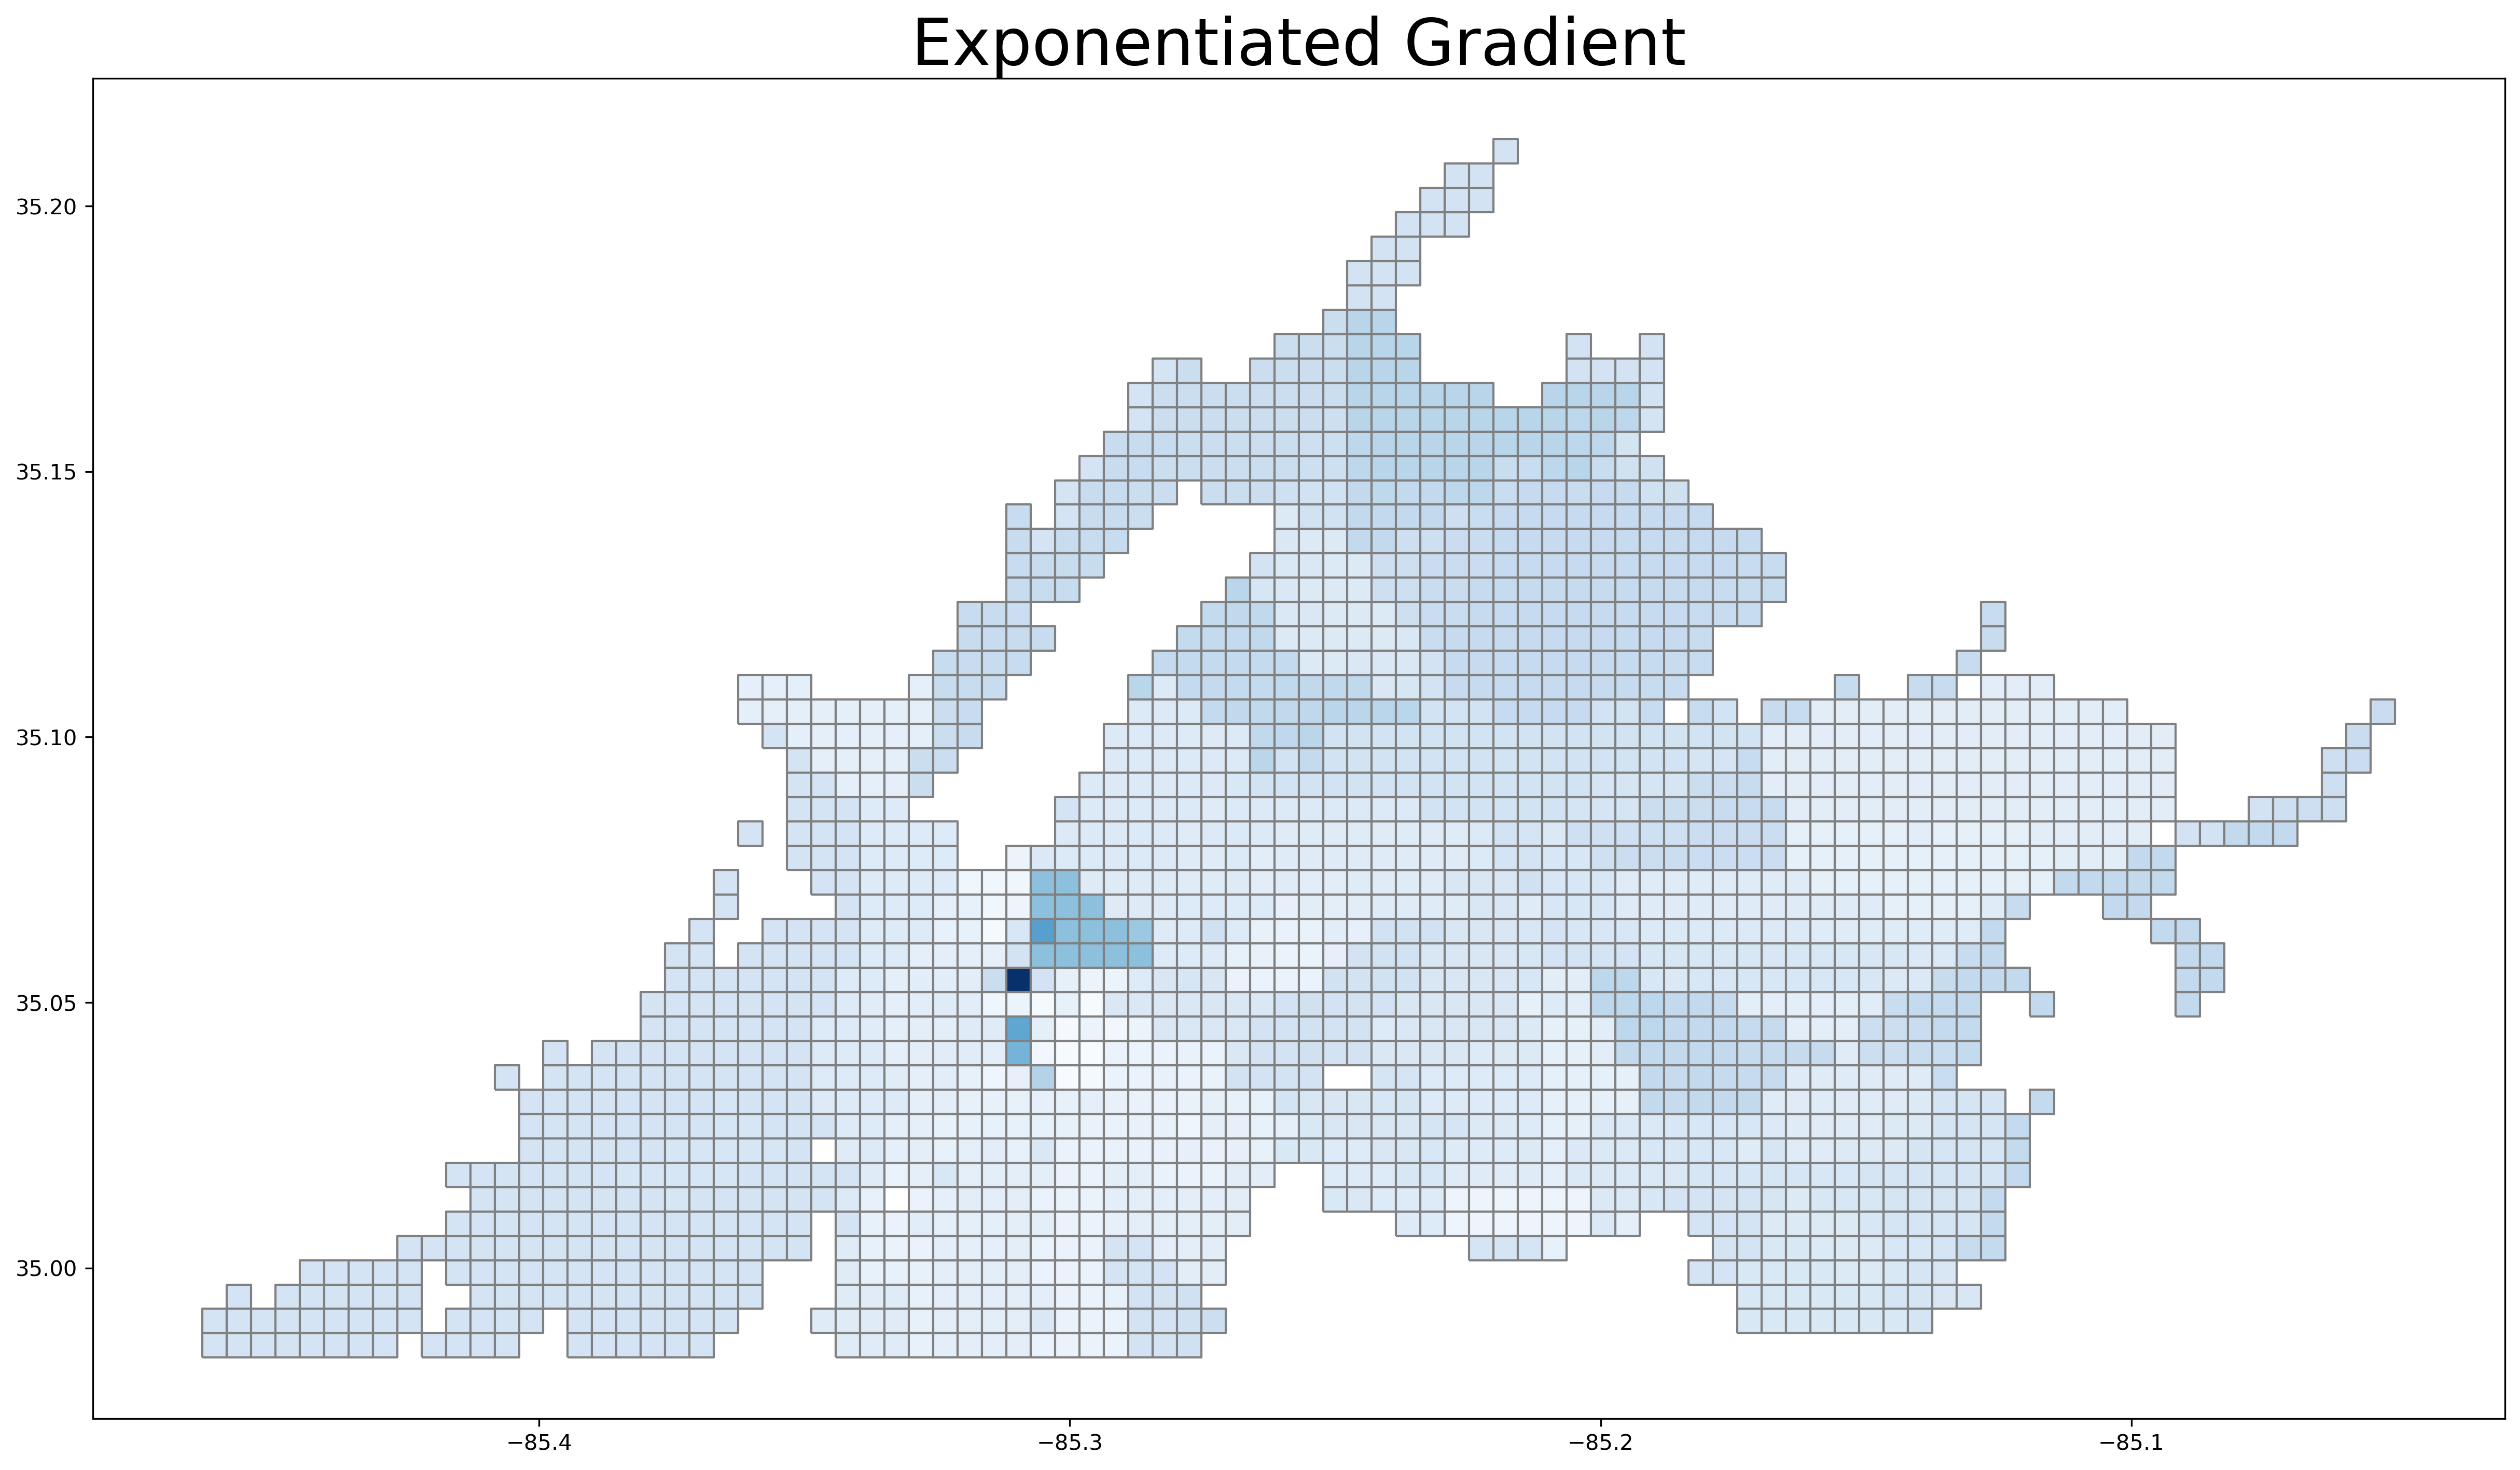

In [45]:
# plot 2
fig, axes = plt.subplots(figsize = (20, 16))

pred_df_yearly_geo.plot(column="new_pred_exp_grad", cmap='Blues',edgecolor = "grey", figsize=(12, 10),  
                    legend = False, legend_kwds={'label': "outflow",'orientation': "vertical"}, ax = axes, vmax = 12000)
axes.set_title("Exponentiated Gradient", fontsize=30)
plt.savefig(os.path.join(save_dir_forecast, "FINAL_EG_" + CITY + FIG_NAME))

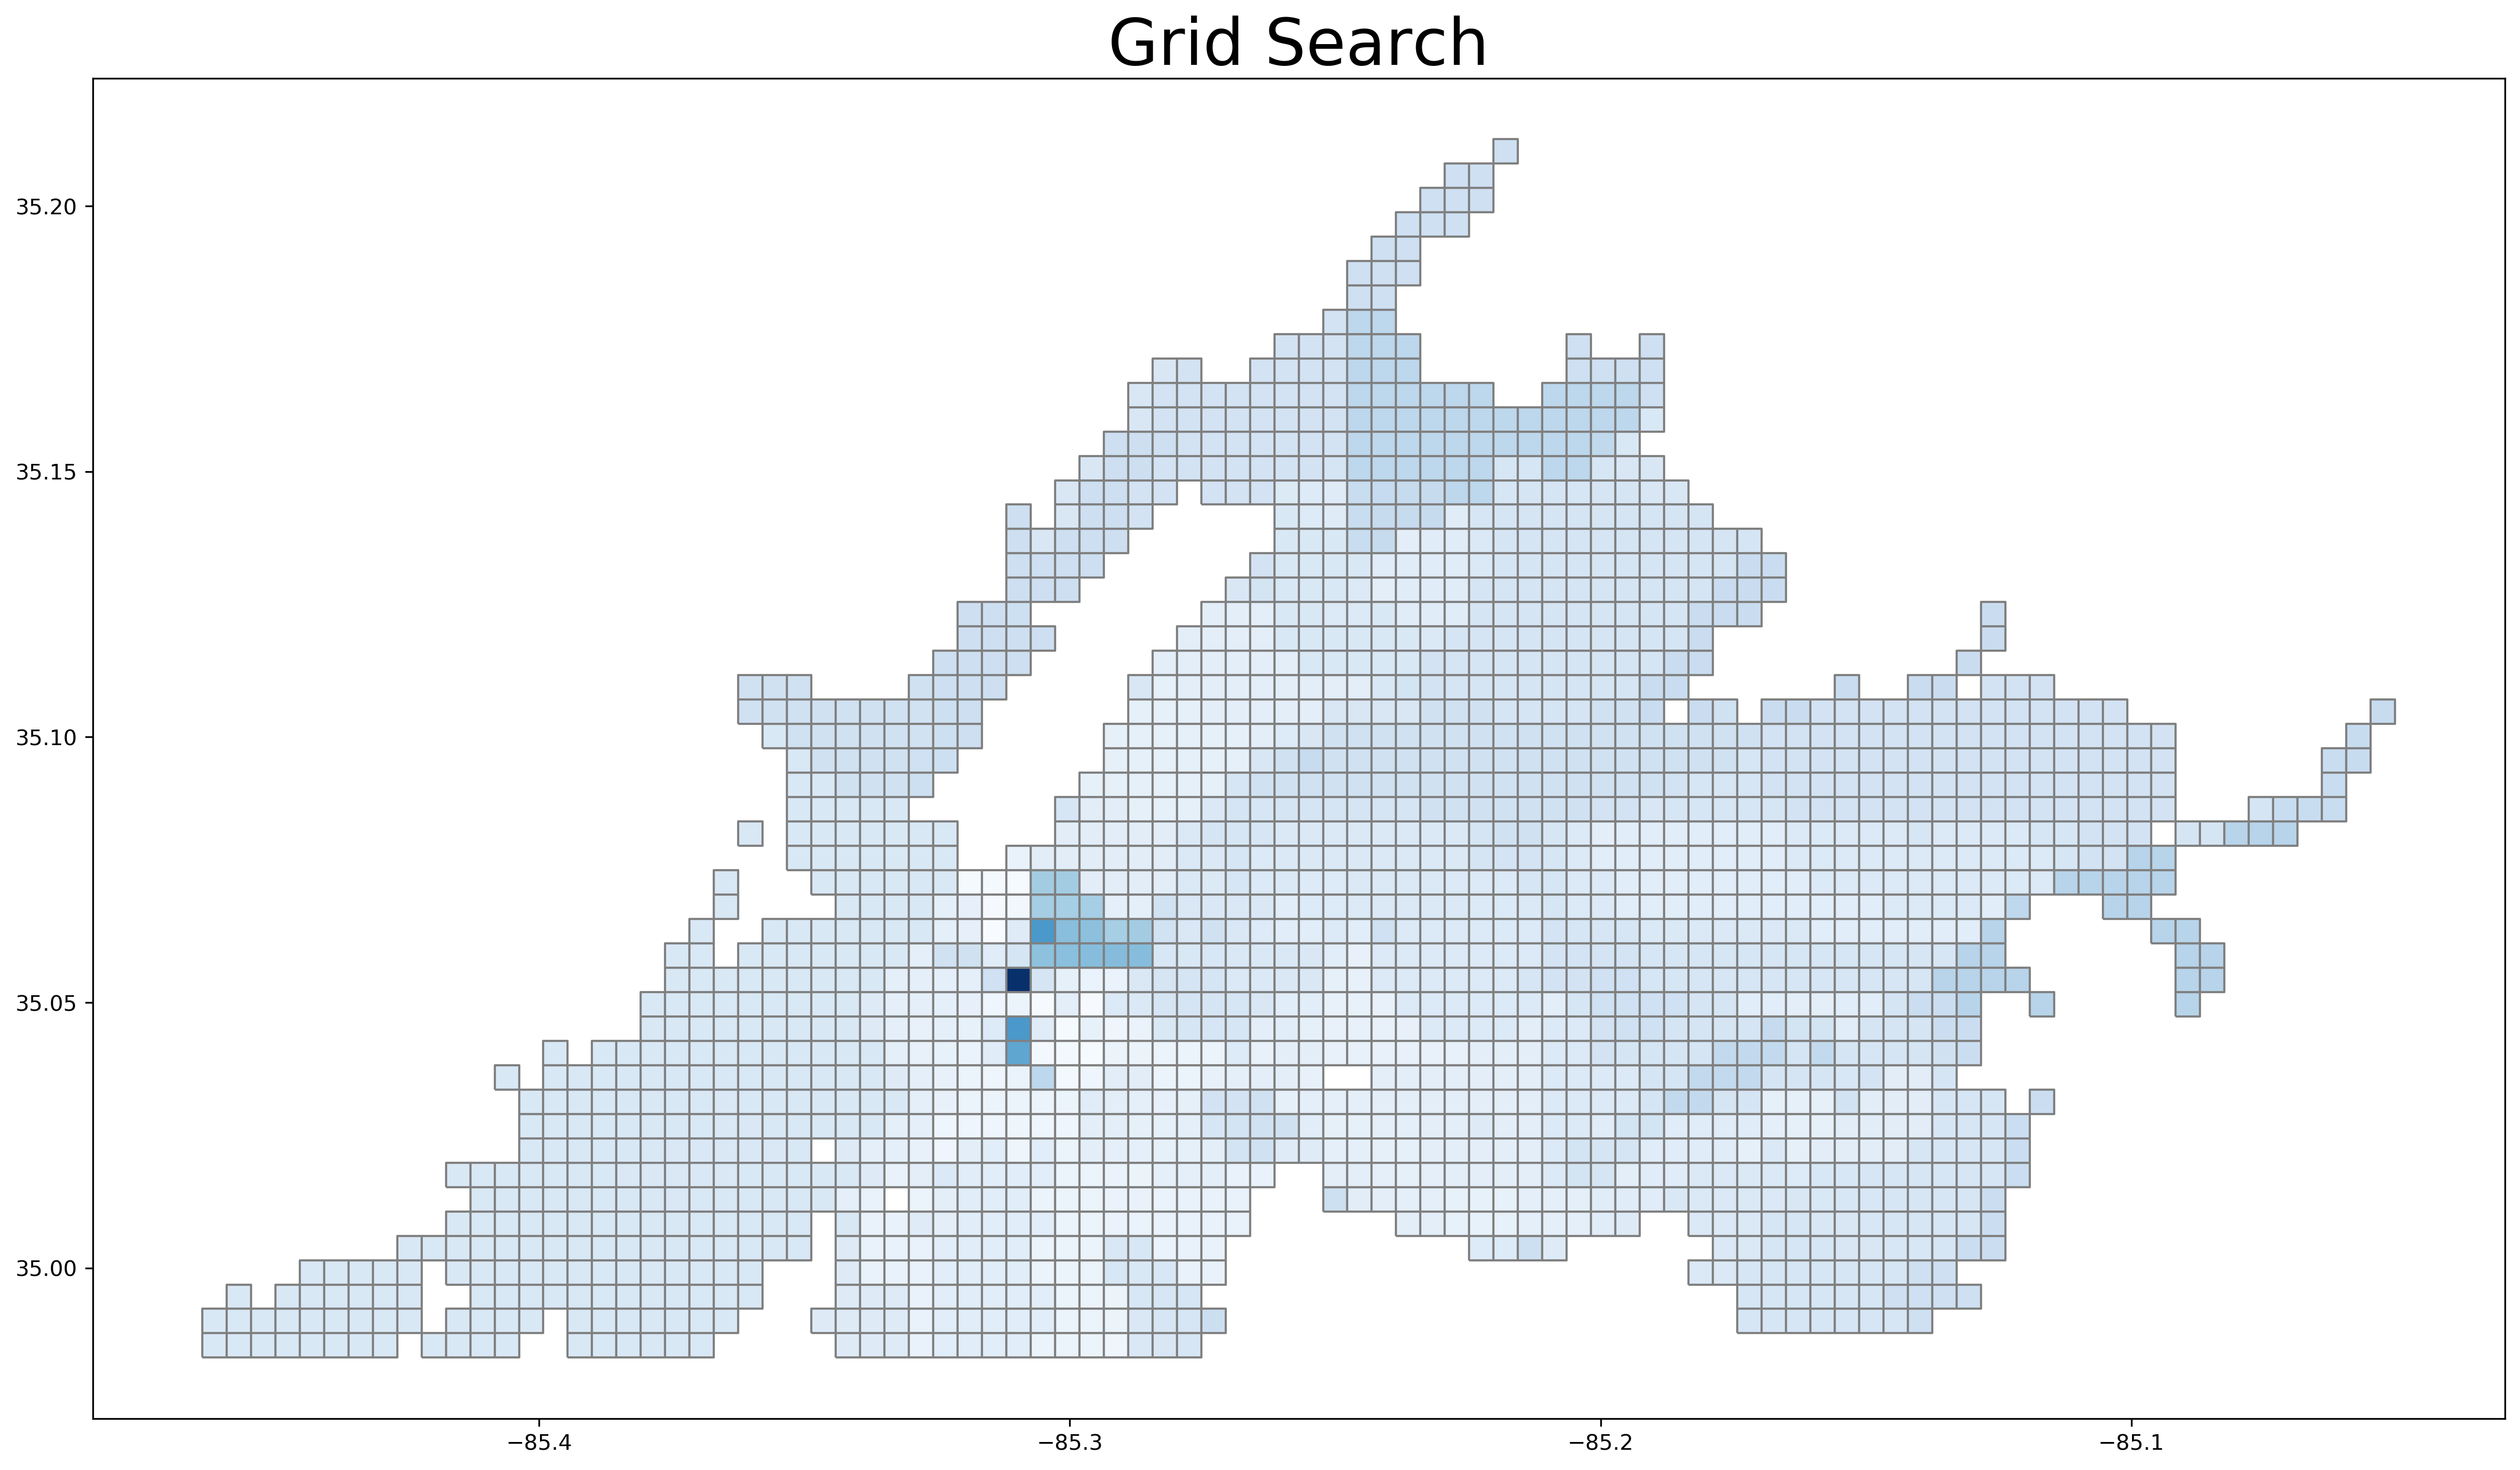

In [46]:
# plot 3
fig, axes = plt.subplots(figsize = (20, 16))

pred_df_yearly_geo.plot(column="new_pred_grid_search", cmap='Blues',edgecolor = "grey", figsize=(12, 10),  
                    legend = False, legend_kwds={'label': "outflow",'orientation': "vertical"}, ax = axes, vmax = 12000)
axes.set_title("Grid Search", fontsize=30)
plt.savefig(os.path.join(save_dir_forecast, "FINAL_GS_" + CITY + FIG_NAME))

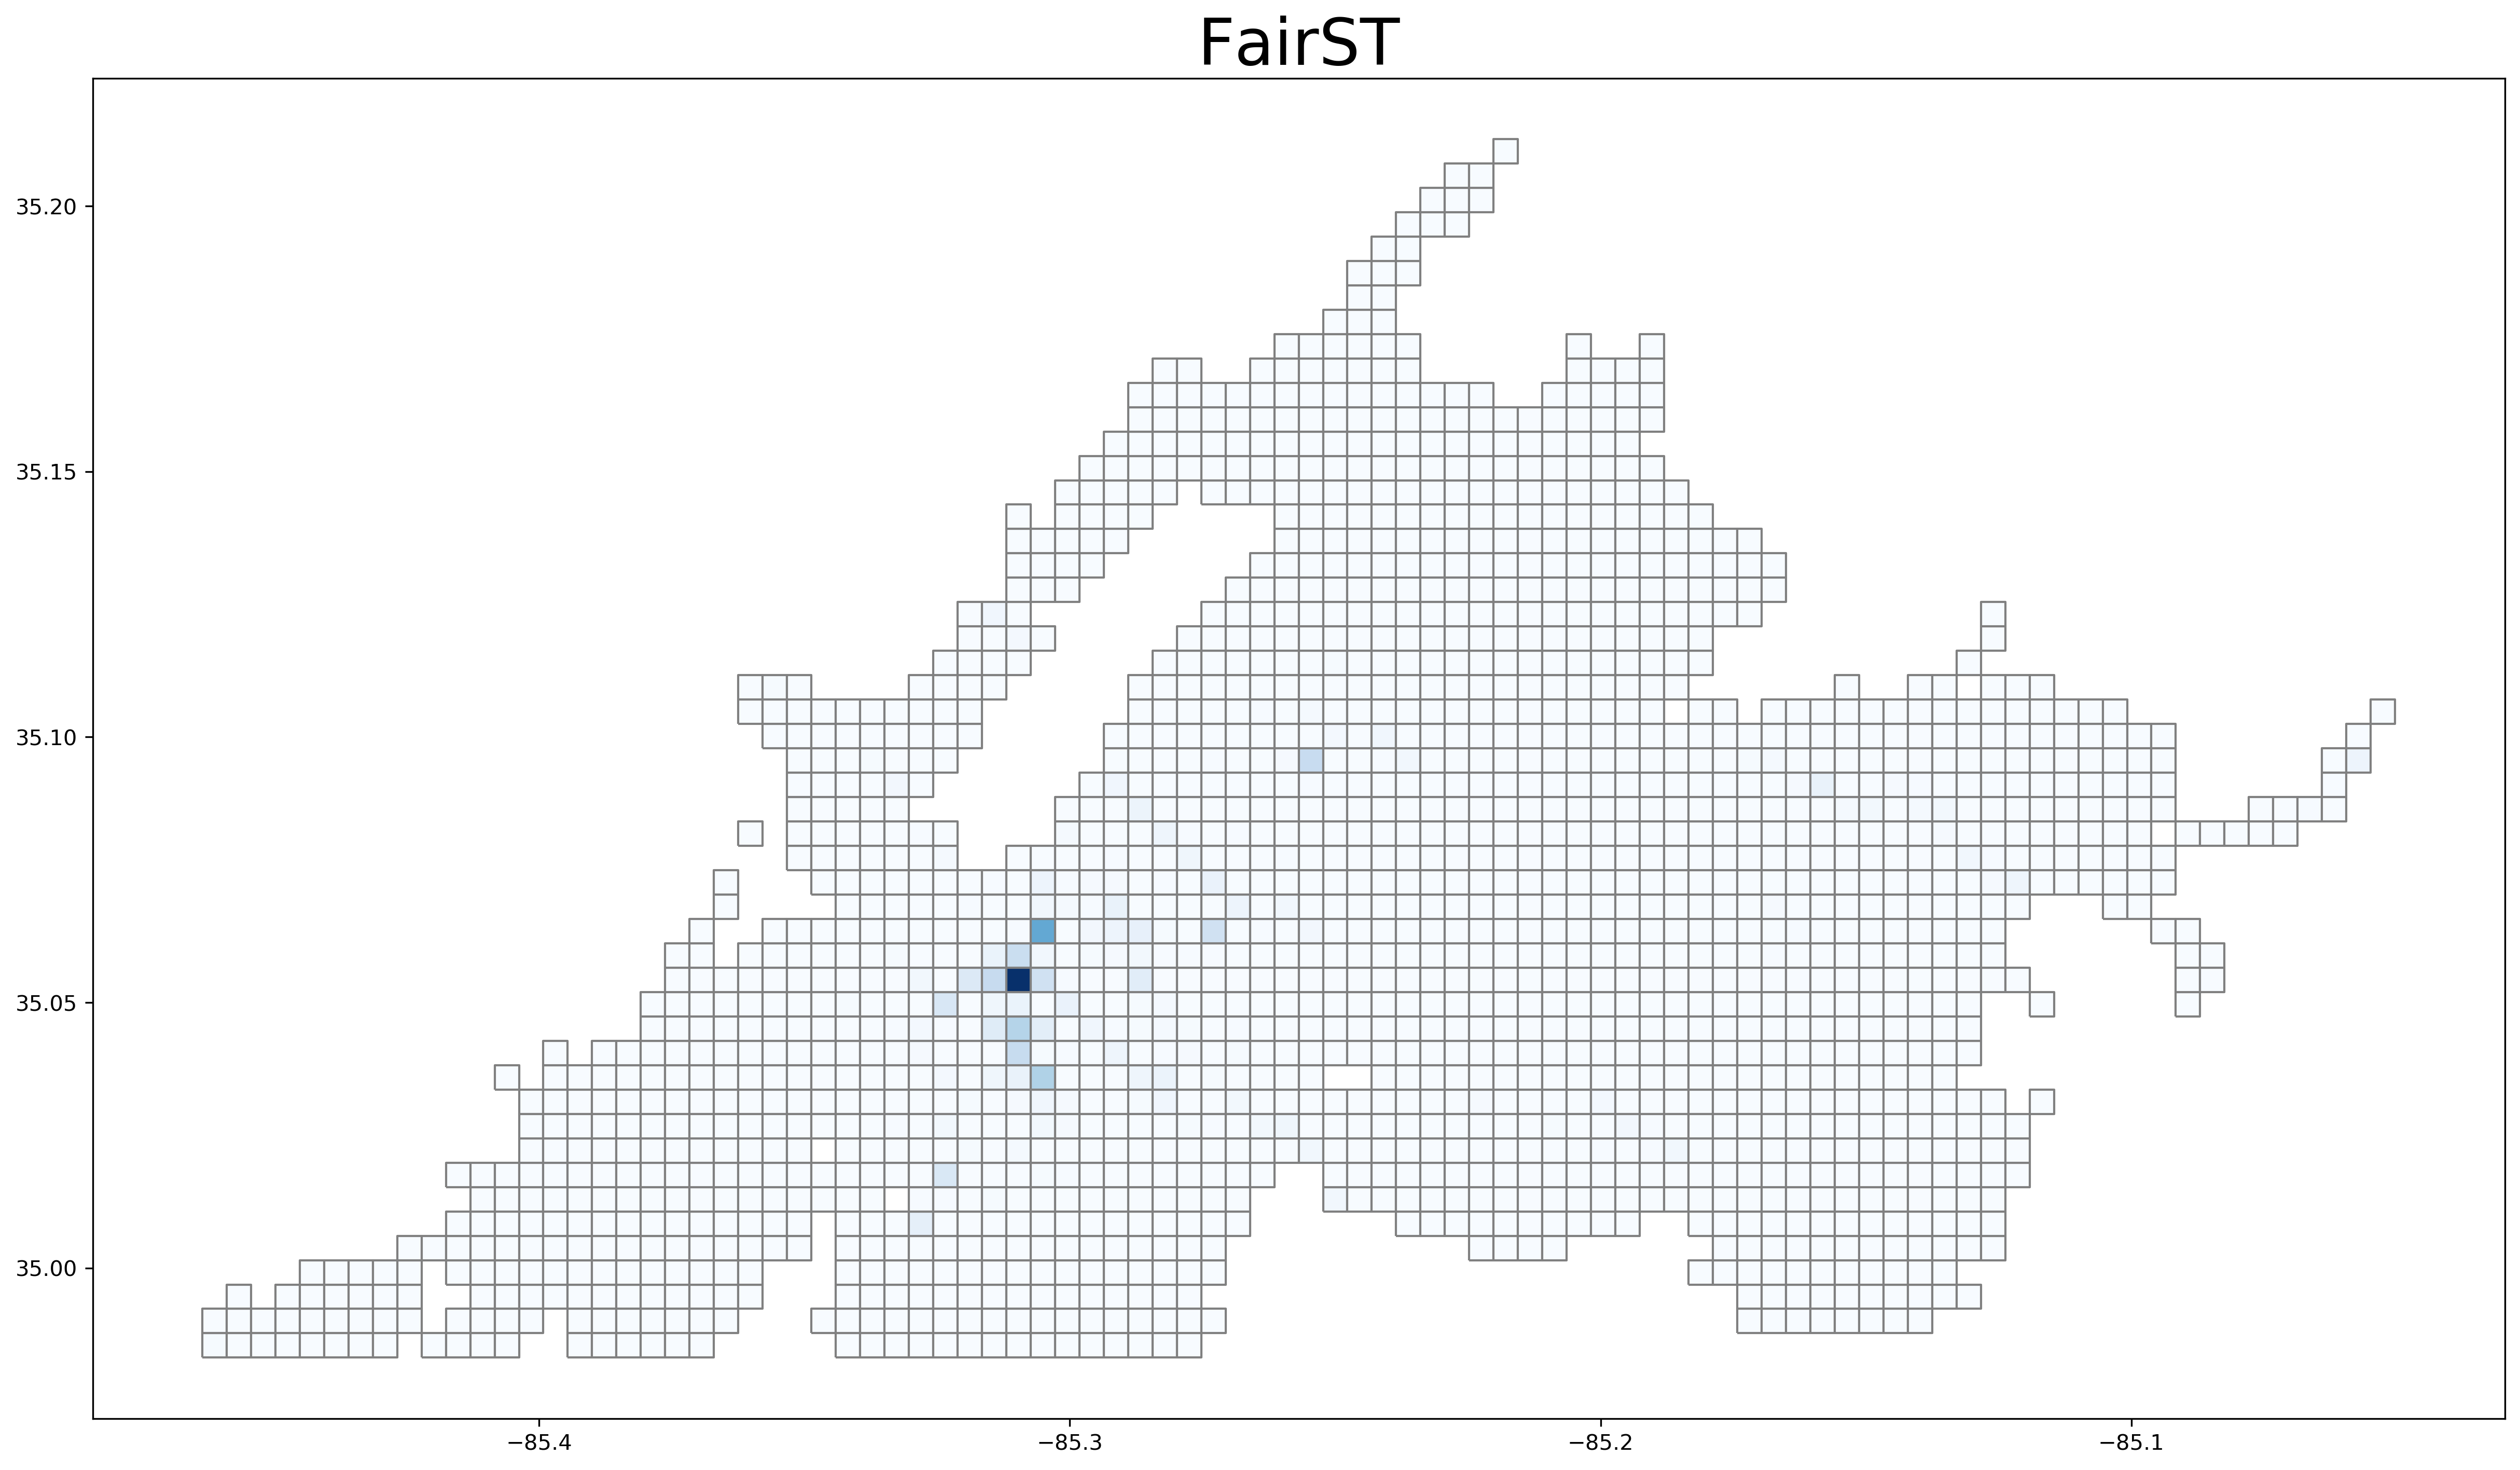

In [47]:
# plot 4
fig, axes = plt.subplots(figsize = (20, 16))

fairst_forecast_inc.plot(column="outflow", cmap='Blues',edgecolor = "grey", figsize=(12, 10),  
                    legend = False, legend_kwds={'label': "outflow",'orientation': "vertical"}, ax = axes, vmax = 12000)

axes.set_title("FairST", fontsize=30)
plt.savefig(os.path.join(save_dir_forecast, "FINAL_fairst_" + CITY + FIG_NAME))

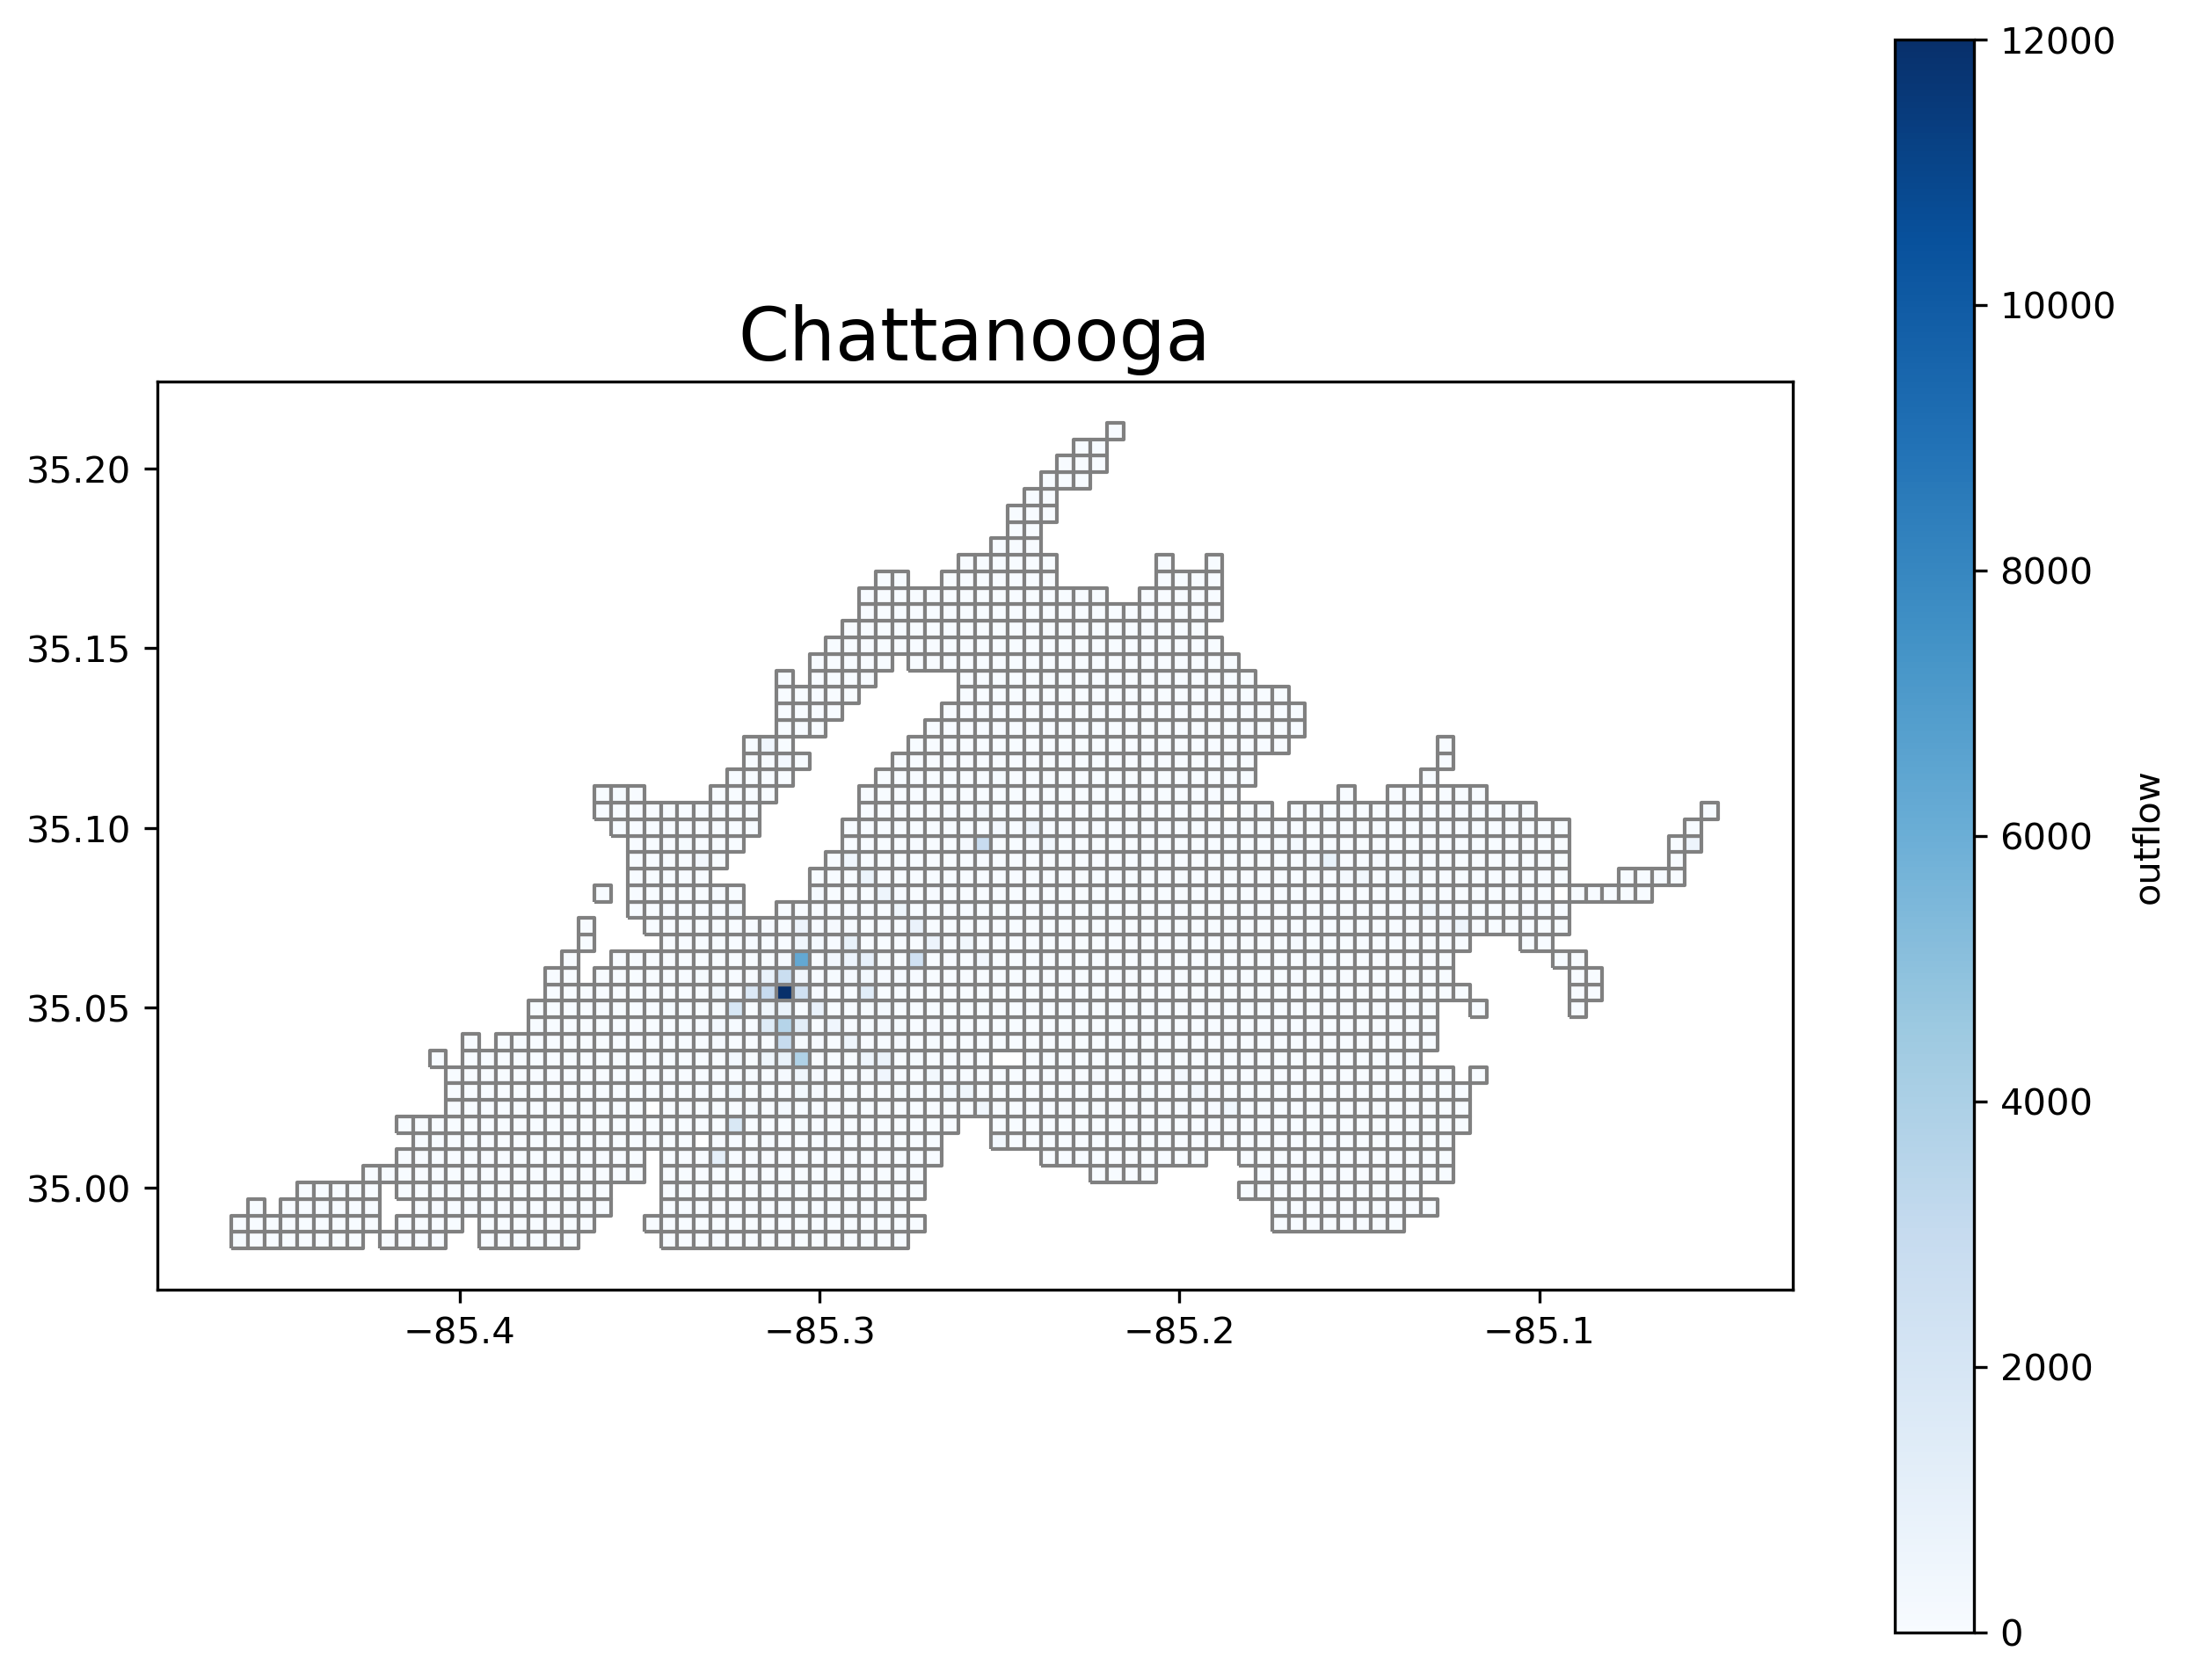

In [48]:
fig, axes = plt.subplots(figsize = (10, 8))

fairst_forecast_inc.plot(column="outflow", cmap='Blues',edgecolor = "grey", figsize=(12, 10),  
                    legend = True, legend_kwds={'label': "outflow",'orientation': "vertical"}, ax = axes, vmax = 12000)
axes.set_title("Chattanooga", fontsize=20)
plt.savefig(os.path.join(save_dir_forecast, "color_bar"))

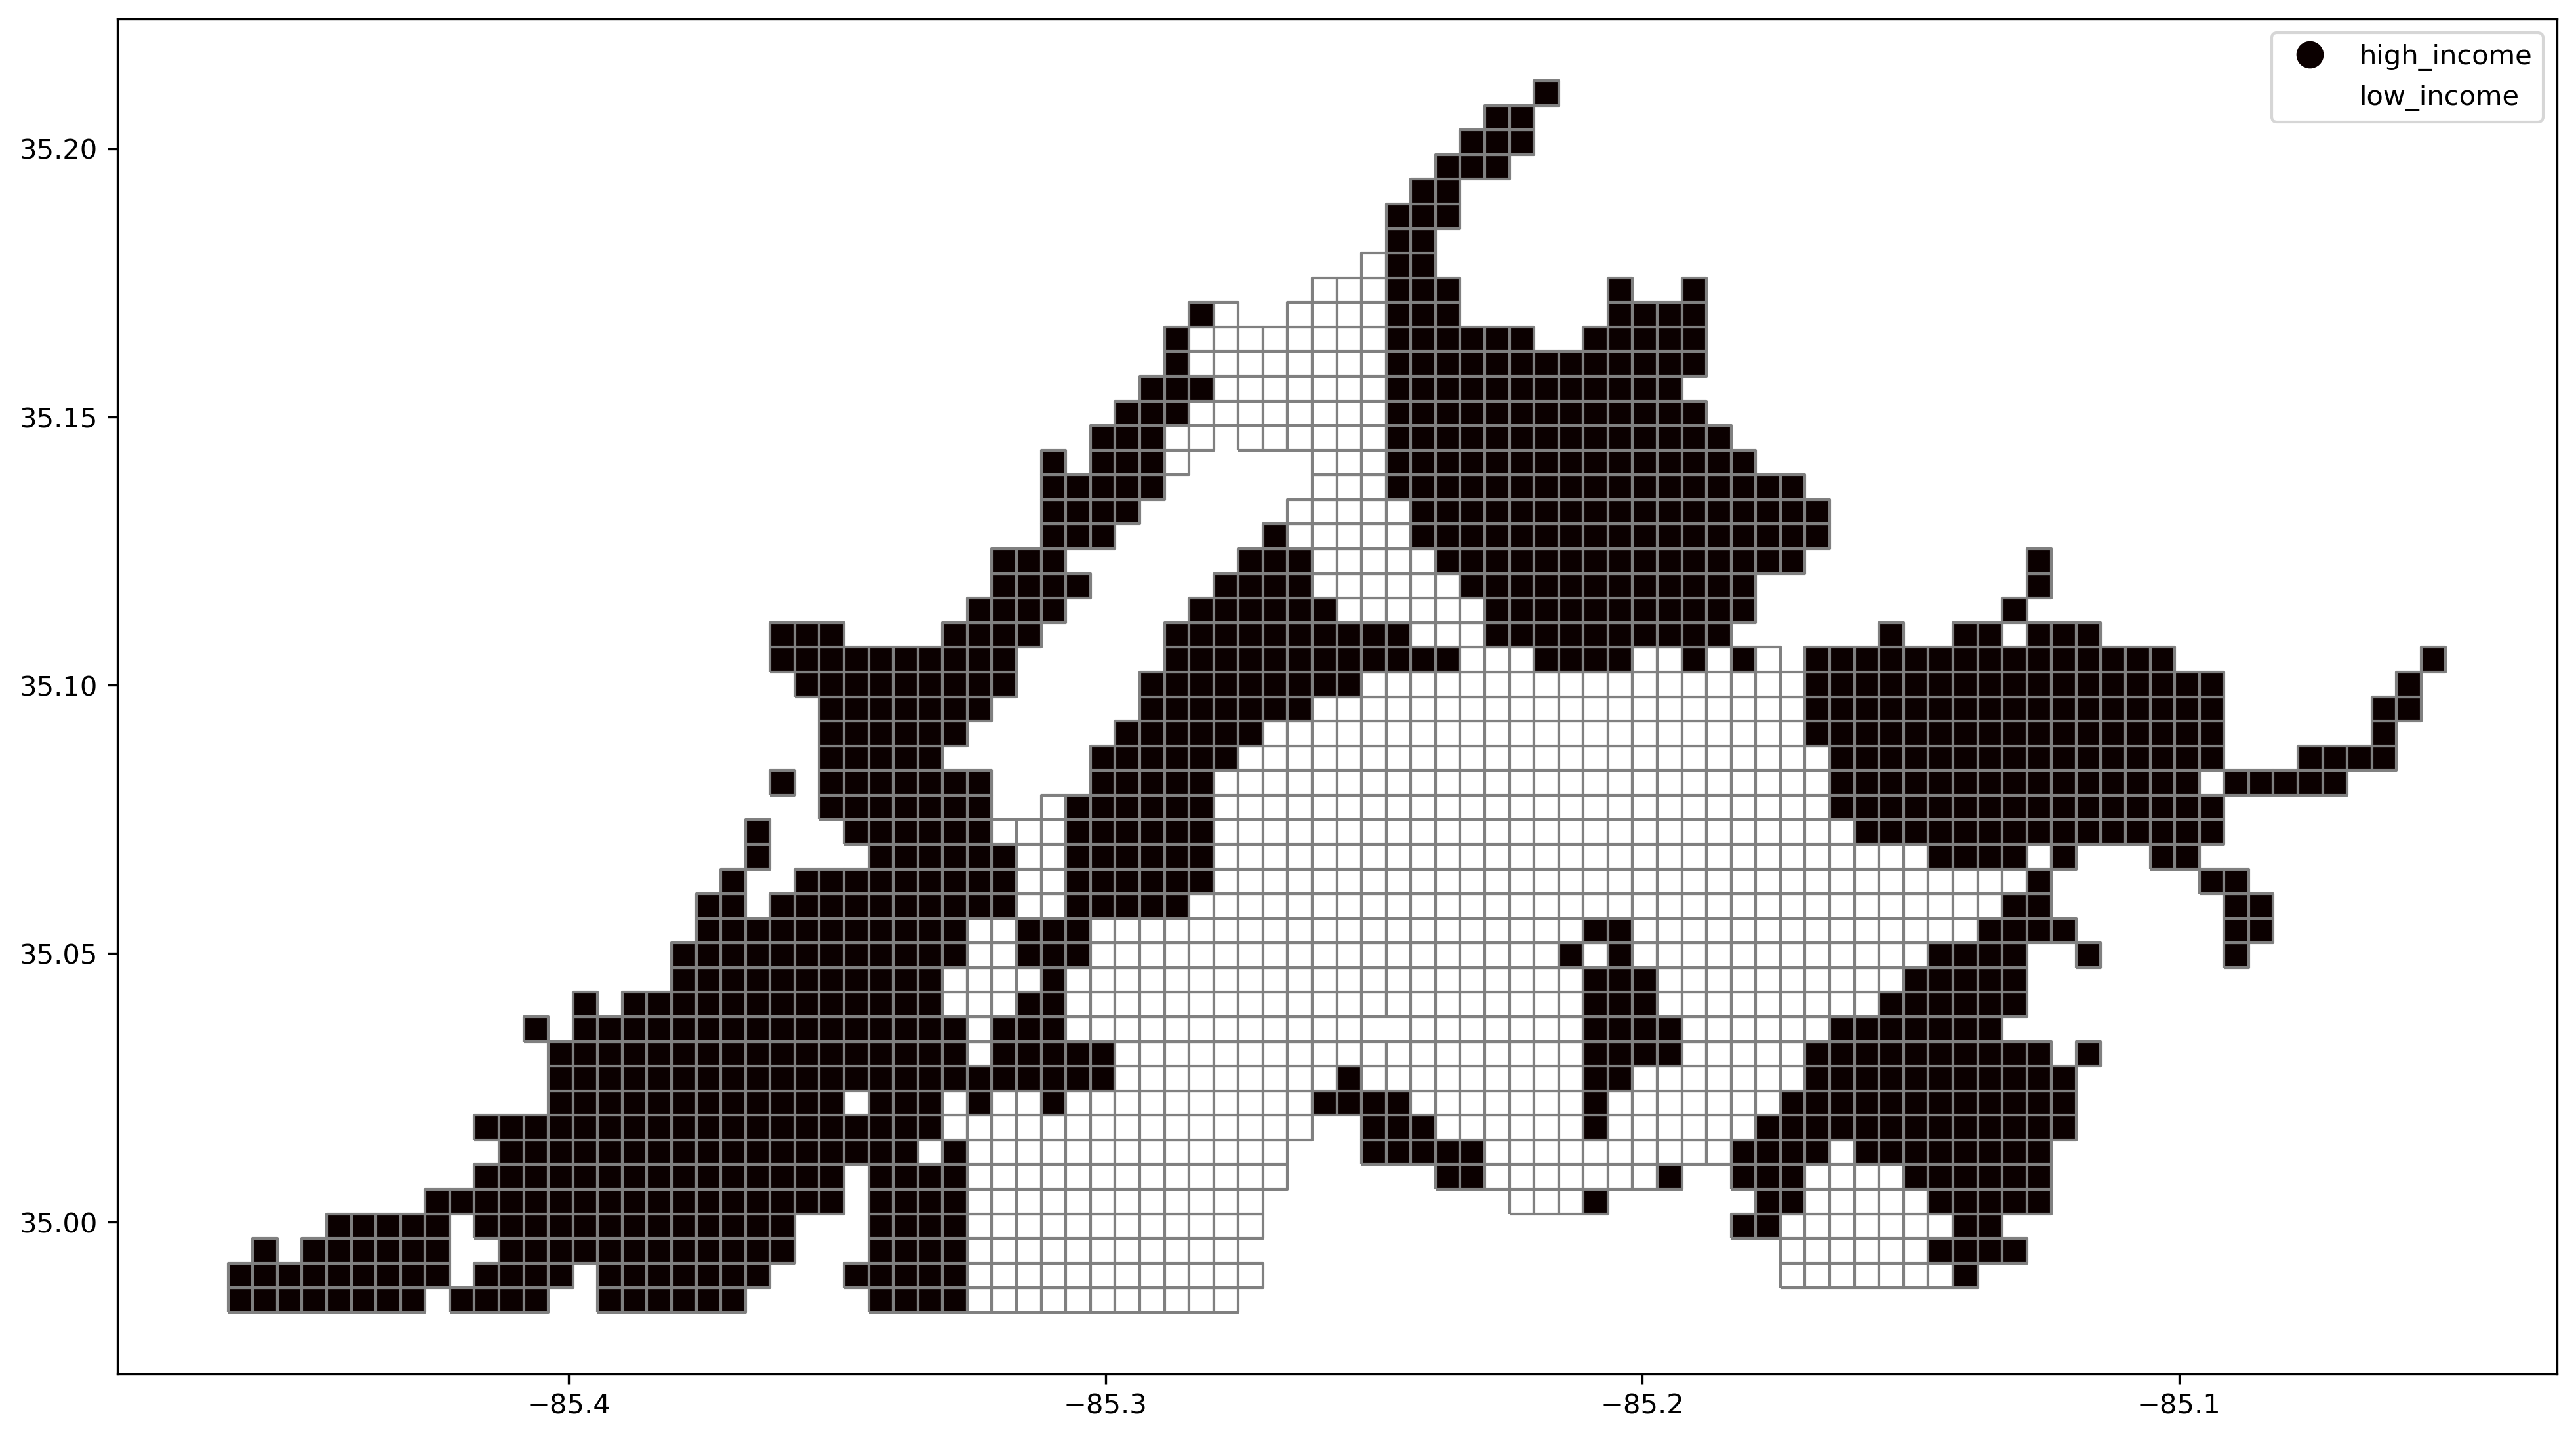

In [56]:
fig, axes = plt.subplots(figsize = (16, 12))
pred_df_yearly_geo.plot(column="income_group", cmap='hot', edgecolor = "grey", figsize=(2, 2),  
                    legend = True, categorical = True, ax = axes)
# axes.set_title("Chattanooga", fontsize = 25)
FIG_NAME = "income_group_distribution"
plt.savefig(os.path.join(save_dir_forecast, CITY + FIG_NAME))
plt.savefig("chatt_income_all")

In [43]:
# # grid search
# fig, axes = plt.subplots(2,2, figsize = (12, 12))

# ax1=axes[0,0]
# ax2=axes[0,1]
# ax3=axes[1,0]
# ax4=axes[1,1]

# pred_random_forest_geo_all.plot(column="old_pred_random_forest", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, ax = ax1, vmax = 7000)
# ax1.set_title("unmitigated random forest", fontsize=15)

# pred_exp_grad_geo_all.plot(column="old_pred_exp_grad", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, ax = ax2, vmax = 7000)
# ax2.set_title("exponentiated gradient", fontsize=15)


# pred_grid_search_geo_all.plot(column="old_pred_grid_search", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, ax = ax3, vmax = 7000)
# ax3.set_title("grid search", fontsize=15)

# income_df.plot(column="bi_income", cmap='hot', edgecolor = "grey", figsize=(2, 2),  
#                     legend = True, categorical = True, ax = ax4)
# ax4.set_title("income groups distribution", fontsize=15)

# fig.suptitle(('Visualisation of outflow forecast for 3 models\n before increase {} station').format(NUM_STATIONS_INC), fontsize=20)

# FIG_NAME = ("fig_before_inc_{}_station").format(NUM_STATIONS_INC)
# plt.savefig(os.path.join(save_dir_forecast, CITY + FIG_NAME))

In [44]:
# # grid search
# fig, axes = plt.subplots(2,2, figsize = (12, 12))

# ax1=axes[0,0]
# ax2=axes[0,1]
# ax3=axes[1,0]
# ax4=axes[1,1]

# pred_random_forest_geo_all.plot(column="new_pred_random_forest", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, ax = ax1, vmax = 8000)
# ax1.set_title("unmitigated random forest", fontsize=15)

# pred_exp_grad_geo_all.plot(column="new_pred_exp_grad", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"},  ax = ax2, vmax = 8000)
# ax2.set_title("exponentiated gradient", fontsize=15)

# pred_grid_search_geo_all.plot(column="new_pred_grid_search", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, ax = ax3, vmax = 8000)
# ax3.set_title("grid search", fontsize=15)


# income_df.plot(column="bi_income", cmap='hot', edgecolor = "grey", figsize=(2, 2),  
#                     legend = True, categorical = True, ax = ax4)
# ax4.set_title("income groups distribution", fontsize=15)

# fig.suptitle(('Visualisation of outflow forecast for 3 models\n after increase {} station').format(NUM_STATIONS_INC), fontsize=20)

# FIG_NAME = ("fig_after_inc_{}_station").format(NUM_STATIONS_INC)
# plt.savefig(os.path.join(save_dir_forecast, CITY + FIG_NAME))

In [45]:
# # grid search
# fig, axes = plt.subplots(2,2, figsize = (12, 12))

# ax1=axes[0,0]
# ax2=axes[0,1]
# ax3=axes[1,0]
# ax4=axes[1,1]

# pred_random_forest_geo_all.plot(column="random_forest_pred_diff", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, ax = ax1, vmax = 1000)
# ax1.set_title("unmitigated random forest", fontsize=15)

# pred_exp_grad_geo_all.plot(column="exp_grad_pred_diff", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, ax = ax2, vmax = 1000)
# ax2.set_title("exponentiated gradient", fontsize=15)

# pred_grid_search_geo_all.plot(column="grid_search_pred_diff", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, ax = ax3, vmax = 1000)
# ax3.set_title("grid search", fontsize=15)

# income_df.plot(column="bi_income", cmap='hot', edgecolor = "grey", figsize=(2, 2),  
#                     legend = True, categorical = True, ax = ax4)
# ax4.set_title("income groups distribution", fontsize=15)

# fig.suptitle(('Visualisation of outflow forecast for 3 models\n difference for increase {} station').format(NUM_STATIONS_INC), fontsize=20)

# FIG_NAME = ("fig_diff_inc_{}_station").format(NUM_STATIONS_INC)
# plt.savefig(os.path.join(save_dir_forecast, CITY + FIG_NAME))

### Analysis 3: difference in increase between two income groups

In [46]:
# def forecast_res_calc(pred_year_df):
#     diff_col = pred_year_df.columns[-3]
#     # print(diff_col)
    
#     high_inc = pred_year_df[pred_year_df["bi_income"] == "high_income"]
#     high_inc_sum_diff = (high_inc[diff_col] / high_inc["stations_added"]).sum()
#     high_inc_sum_diff_avg = high_inc_sum_diff/len(high_inc)
    
#     low_inc = pred_year_df[pred_year_df["bi_income"] == "low_income"]
#     low_inc_sum_diff = (low_inc[diff_col] / low_inc["stations_added"]).sum()
#     low_inc_sum_diff_avg = low_inc_sum_diff/len(low_inc)
    
# #     print(high_inc_sum_diff_avg)
# #     print(low_inc_sum_diff_avg)
#     diff = high_inc_sum_diff_avg - low_inc_sum_diff_avg
#     ratio = low_inc_sum_diff_avg / high_inc_sum_diff_avg
    
#     return high_inc_sum_diff_avg, low_inc_sum_diff_avg, diff, ratio

In [47]:
# forc_res_summary = pd.DataFrame(0, columns = ["high_inc_sum_diff_avg", "low_inc_sum_diff_avg","diff", "ratio"],
#                                    index = ["random_forest", "exp_grad", "grid_search"])

In [48]:
# forc_res_rf = forecast_res_calc(pred_random_forest_yearly)
# forc_res_eg = forecast_res_calc(pred_exp_grad_yearly)
# forc_res_gs = forecast_res_calc(pred_grid_search_yearly)

# forc_res_summary.loc["random_forest", "high_inc_sum_diff_avg"] = forc_res_rf[0]
# forc_res_summary.loc["random_forest", "low_inc_sum_diff_avg"] = forc_res_rf[1]
# forc_res_summary.loc["random_forest", "diff"] = forc_res_rf[2]
# forc_res_summary.loc["random_forest", "ratio"] = forc_res_rf[3]

# forc_res_summary.loc["exp_grad", "high_inc_sum_diff_avg"] = forc_res_eg[0]
# forc_res_summary.loc["exp_grad", "low_inc_sum_diff_avg"] = forc_res_eg[1]
# forc_res_summary.loc["exp_grad", "diff"] = forc_res_eg[2]
# forc_res_summary.loc["exp_grad", "ratio"] = forc_res_eg[3]

# forc_res_summary.loc["grid_search", "high_inc_sum_diff_avg"] = forc_res_gs[0]
# forc_res_summary.loc["grid_search", "low_inc_sum_diff_avg"] = forc_res_gs[1]
# forc_res_summary.loc["grid_search", "diff"] = forc_res_gs[2]
# forc_res_summary.loc["grid_search", "ratio"] = forc_res_gs[3]

___

In [48]:
def forecast_res_calc(pred_df_yearly_geo):
    
    high_inc = pred_df_yearly_geo[pred_df_yearly_geo["income_group"] == "high_income"]
    low_inc = pred_df_yearly_geo[pred_df_yearly_geo["income_group"] == "low_income"]

    random_forest_diff =  ((low_inc.new_pred_random_forest.sum())/len(low_inc)) / ((high_inc.new_pred_random_forest.sum())/len(high_inc))
    exp_grad_diff =  ((low_inc.new_pred_exp_grad.sum())/len(low_inc)) / ((high_inc.new_pred_exp_grad.sum())/len(high_inc))
    grid_search_diff =  ((low_inc.new_pred_grid_search.sum())/len(low_inc)) / ((high_inc.new_pred_grid_search.sum())/len(high_inc))

    return random_forest_diff, exp_grad_diff, grid_search_diff

In [49]:
# forc_res_summary = pd.DataFrame(0, columns = ["random_forest_diff", "exp_grad_diff", "grid_search_diff"], index = ["inc_{}_station".format(NUM_STATIONS_INC)])

In [50]:
FILE_NAME = "forc_res_summary.csv"

PATH1 = os.path.join(save_dir_forecast, CITY + FILE_NAME)

if path.exists(PATH1):
    forc_res_summary = pd.read_csv(PATH1, index_col = 0)
else:
    forc_res_summary = pd.DataFrame(0, columns = ["random_forest_ratio", "exp_grad_ratio", "grid_search_ratio"], index = ["inc_{}_station".format(NUM_STATIONS_INC)])

In [51]:
forc_res_summary.loc["inc_{}_station".format(NUM_STATIONS_INC), "random_forest_ratio"] = forecast_res_calc(pred_df_yearly_geo)[0]
forc_res_summary.loc["inc_{}_station".format(NUM_STATIONS_INC), "exp_grad_ratio"] = forecast_res_calc(pred_df_yearly_geo)[1]
forc_res_summary.loc["inc_{}_station".format(NUM_STATIONS_INC), "grid_search_ratio"] = forecast_res_calc(pred_df_yearly_geo)[2]

In [52]:
fairst_high_inc = fairst_forecast_inc[fairst_forecast_inc["income_group"] == 1]
fairst_low_inc = fairst_forecast_inc[fairst_forecast_inc["income_group"] == 0]
fairst_high_inc_avg = ((fairst_high_inc.outflow.sum())/len(fairst_high_inc))
fairst_low_inc_avg = ((fairst_low_inc.outflow.sum())/len(fairst_low_inc))

fairst_ratio = fairst_low_inc_avg/fairst_high_inc_avg

In [53]:
forc_res_summary.loc["inc_{}_station".format(NUM_STATIONS_INC), "fairst_ratio"] = fairst_ratio

In [54]:
forc_res_summary.to_csv(os.path.join(save_dir_forecast, CITY + FILE_NAME))
forc_res_summary

,random_forest_ratio,exp_grad_ratio,grid_search_ratio,fairst_ratio
inc_1_station,0.896944,0.836463,0.85144,0.950756
inc_2_station,0.899609,0.839858,0.85731,0.950756
